
Found 80 shot files in /p/ltxdata/NBI/WCAL
Shot range: 112559 to 113305

=== Fetching Beam Energies from MDSplus ===
problem occurred retrieving data for node .oper_diags.ltx_nbi.source_diags.i_hvps
problem occurred retrieving data for node .oper_diags.ltx_nbi.source_diags.v_hvps
Shot 112559: No data
Shot 112560: 2.05 kJ | 12.31 kV | 16.416 A | Beam on: 0.466s - 0.476s
Shot 112561: 2.19 kJ | 12.32 kV | 17.552 A | Beam on: 0.466s - 0.476s
Shot 112562: 2.18 kJ | 12.33 kV | 17.447 A | Beam on: 0.466s - 0.476s
Shot 112563: No data
problem occurred retrieving data for node .oper_diags.ltx_nbi.source_diags.i_hvps
problem occurred retrieving data for node .oper_diags.ltx_nbi.source_diags.v_hvps
Shot 112564: No data
problem occurred retrieving data for node .oper_diags.ltx_nbi.source_diags.i_hvps
problem occurred retrieving data for node .oper_diags.ltx_nbi.source_diags.v_hvps
Shot 112565: No data
problem occurred retrieving data for node .oper_diags.ltx_nbi.source_diags.i_hvps
problem occurr

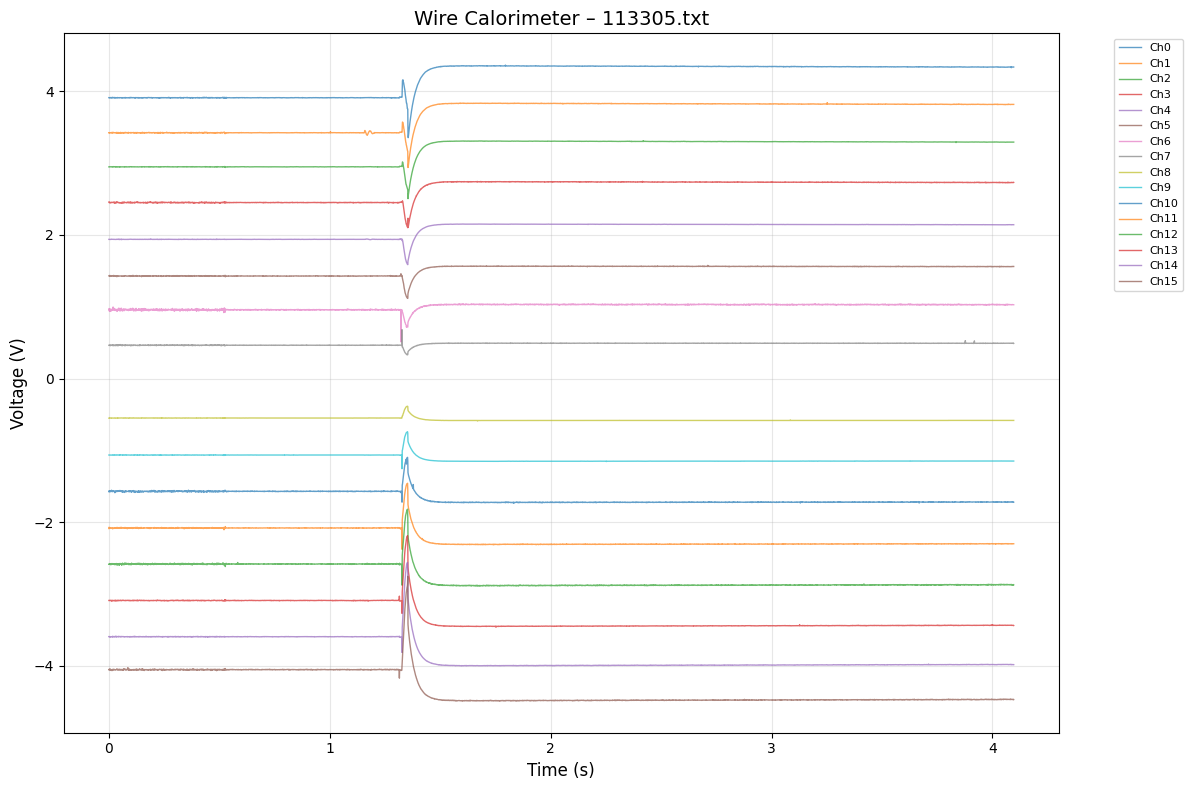

In [94]:
# NBI Wire Calorimeter Analysis
# H. Gajani

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/u/hgajani/LTXb-py-main/LTXb-py-main')
from bills_LTX_MDSplus_toolbox import get_tree_conn, get_data
import MDSplus as mds

# Wire properties
WIRE_CURRENT = 0.7  # Amps
TCR = 0.0045  # Tungsten temp coefficient

def get_avg_beam_power(shot, v_thresh=5000.0):
    """Fetch total beam energy, current, and voltage from MDSplus during beam-on period."""
    try:
        if shot > 200000:
            treename = 'ltx_nbi'
            prefix = ''
        else:
            treename = 'ltx_b'
            prefix = '.oper_diags.ltx_nbi'
        
        tree = get_tree_conn(shot, treename=treename)
        (ti, ib) = get_data(tree, f'{prefix}.source_diags.i_hvps')
        (tv, vb) = get_data(tree, f'{prefix}.source_diags.v_hvps')
        
        ib = np.interp(tv, ti, ib)
        pb = ib * vb / 1000.0  # kW
        
        mask = vb > v_thresh
        if np.any(mask):
            # Integrate power over time to get total energy
            tv_beam = tv[mask]
            pb_beam = pb[mask]
            vb_beam = vb[mask]
            ib_beam = ib[mask]
            total_energy = np.trapz(pb_beam, tv_beam)  # kJ (kW * s)
            beam_on_time = tv_beam[0]   # Time when beam turns on
            beam_off_time = tv_beam[-1]  # Time when beam turns off
            avg_beam_voltage = np.mean(vb_beam) / 1000.0  # Convert to kV
            avg_beam_current = np.mean(ib_beam)  # Amps
            return total_energy, beam_on_time, beam_off_time, avg_beam_voltage, avg_beam_current
        else:
            return np.nan, np.nan, np.nan, np.nan, np.nan
            
    except (mds.mdsExceptions.TreeNODATA, Exception) as e:
        print(f'Warning: Could not fetch beam power for shot {shot}: {e}')
        return np.nan, np.nan, np.nan, np.nan, np.nan

# Shot list

"""shot_list = [
    112209, 112210, 112211, 112212, 112213,
    112249, 112251, 112253, 112254, 112255, 112256,
    112268, 112269, 112270, 112271,

    112359, 112360, 112361, 112362, 112364,
    112394, 112395, 112396, 112397, 112398,
    112401, 112402, 112403, 112404, 112405, 112406, 112407,
    112409, 112410, 112411,
    112413, 112414, 112416, 112417, 112418, 112419, 112420,
    112421, 112422, 112423, 112424, 112425,
    112427, 112428, 112432, 112433, 112435,

    112469, 112470, 112471, 112472,
    112474, 112475, 112477, 112478, 112479,
    112480, 112481, 112482, 112483, 112484,

    112524, 112525, 112526, 112527, 112528, 112529,
    112531, 112532, 112533, 112534, 112535, 112536,
    112537, 112538, 112539, 112540, 112541, 112542, 112543,
    112544, 112545, 112546, 112547, 112548, 112549, 112550,
    112552, 112553, 112554, 112555, 112556, 112557, 112558,
    112668, 112669, 112670, 112671, 112672, 112673, 112674, 112675,
    112676, 112677
    112725, 112726,
    113260, 113261,113262,113263,113264,113268,113269,113270,
    113271,113273,113274,113275,113276,113277,113278,113279,113280,113281,113282,113283,
    113297,113298,113299,113300,113301,113302,113303,113304,113305]
shot_list = [113260, 113261,113262,113263,113264,113268,113269,113270,113271,113273,113274,113275,113276,113277,113278,113279,113280,113281,113282,113283,113297,113298,113299,113301,113303,113304,113305]"""

# Automatically load all shot files from WCAL folder
base_path = Path("/p/ltxdata/NBI/WCAL")
all_files = sorted(base_path.glob("*.txt"))

# Filter to only files with numeric names (shot numbers)
file_list = []
shot_list = []
for f in all_files:
    try:
        shot_num = int(f.stem)
        file_list.append(f)
        shot_list.append(shot_num)
    except ValueError:
        # Skip non-numeric files (like backup.txt)
        print(f"Skipping non-numeric file: {f.name}")

print(f"\nFound {len(file_list)} shot files in {base_path}")
print(f"Shot range: {min(shot_list)} to {max(shot_list)}")


# Single shot analysis
#shot_list = [111920]
#base_path = Path("/p/ltxdata/NBI/WCAL")
file_list = [base_path / f"{shot}.txt" for shot in shot_list]

def find_data_start(path: Path) -> int:
    """Find where actual data starts in LVM file."""
    with open(path, "r", errors="ignore") as f:
        end = -1
        for i, line in enumerate(f):
            if line.strip() == "***End_of_Header***":
                end = i
    return end + 1

def load_lvm(path: Path):
    """Load LVM file into dataframe."""
    start_row = find_data_start(path)
    df = pd.read_csv(path, sep="\t", skiprows=start_row, engine="python")
    df = df.dropna(axis=1, how="all").reset_index(drop=True)
    df["Time (s)"] = df.index * 1e-3  # 1 kHz sampling
    for c in df.columns:
        if c not in ["Time (s)", "Comment"]:
            df[c] = pd.to_numeric(df[c])
    return df

#load all datasets
datasets = {f.name: load_lvm(f) for f in file_list}
time_col = "Time (s)"

#building a table to manually confirm data
def build_power_table(df, shot_name, beam_energy_kj):
    channel_cols = [c for c in df.columns if c not in ["Time (s)", "Comment"]]
    rows = []

    for idx, col in enumerate(channel_cols):
        y = df[col].values
        
        # V_1: 2 seconds of data at t=0 (indices 0 to 2000)
        v1_start = 0
        v1_end = 2000
        V_1 = np.mean(y[v1_start:v1_end])
        R_1 = V_1 / WIRE_CURRENT
        
        # V_2: 2 seconds of data at t=1.8s (index 1800 to 3800, since 1.8s * 1000 = 1800)
        v2_start = 1800
        v2_end = v2_start + 2000
        V_2 = np.mean(y[v2_start:v2_end])
        R_2 = V_2 / WIRE_CURRENT

        # ΔR and ΔT
        delta_R = R_2 - R_1
        delta_T = delta_R / (R_1 * TCR) if R_1 != 0 else np.nan
        delta_V = V_2 - V_1
        # Normalize by beam energy
        delta_T_normalized = delta_T / beam_energy_kj if (not np.isnan(delta_T) and beam_energy_kj > 0) else np.nan
        
        rows.append({
            "Shot": shot_name,
            "Channel": f"Channel {idx}",
            "Voltage 1 (V)": V_1,  # 2s average at t=0
            "Voltage 2 (V)": V_2,  # 2s average at t=1.8s
            "Delta_V (V)": delta_V, 
            "ΔT (°C)": delta_T,
            "Beam Energy (kJ)": beam_energy_kj,
            "ΔT/E (°C/kJ)": delta_T_normalized
        })

    return pd.DataFrame(rows)

# Process all shots and collect results
all_results = []
beam_energies = {}
beam_timings = {}  # Store beam on/off times
beam_voltages = {}  # Store beam voltages
beam_currents = {}  # Store beam currents

print("\n=== Fetching Beam Energies from MDSplus ===")
for shot_file, df in datasets.items():
    shot_number = int(Path(shot_file).stem)
    beam_energy, t_on, t_off, beam_voltage, beam_current = get_avg_beam_power(shot_number)
    beam_energies[shot_file] = beam_energy
    beam_timings[shot_file] = (t_on, t_off)
    beam_voltages[shot_file] = beam_voltage
    beam_currents[shot_file] = beam_current
    if not np.isnan(beam_energy):
        print(f"Shot {shot_number}: {beam_energy:.2f} kJ | {beam_voltage:.2f} kV | {beam_current:.3f} A | Beam on: {t_on:.3f}s - {t_off:.3f}s")
    else:
        print(f"Shot {shot_number}: No data")

print("\n=== Processing Wire Calorimeter Data ===")

# Open file to write all tables
all_tables_file = Path.home() / "all_shot_tables.txt"
with open(all_tables_file, 'w') as f:
    f.write("NBI Wire Calorimeter Analysis - All Shot Tables\n")
    f.write("=" * 100 + "\n\n")
    
    for shot_file, df in datasets.items():
        beam_energy = beam_energies[shot_file]
        table = build_power_table(df, shot_file, beam_energy)
        all_results.append(table)
        
        # Print to console
        print(f"\n\n{'='*80}")
        print(f"Shot: {shot_file} | Beam Energy: {beam_energy:.2f} kJ")
        print('='*80)
        print(table[['Channel', 'Voltage 1 (V)', 'Voltage 2 (V)', 'Delta_V (V)', 
                     'ΔT (°C)', 'ΔT/E (°C/kJ)']].to_string(index=False))
        
        # Write to file
        f.write("\n\n" + "="*100 + "\n")
        f.write(f"Shot: {shot_file} | Beam Energy: {beam_energy:.2f} kJ\n")
        f.write("="*100 + "\n")
        f.write(table[['Channel', 'Voltage 1 (V)', 'Voltage 2 (V)', 'Delta_V (V)', 
                       'ΔT (°C)', 'ΔT/E (°C/kJ)']].to_string(index=False))
        f.write("\n")

print(f"\n\nProcessed {len(all_results)} shots total")
print(f"All shot tables saved to: {all_tables_file}")

# Get the last shot's data for plotting
df = datasets[list(datasets.keys())[-1]]
first_file = list(datasets.keys())[-1]

# Plot all channels on one figure ONLY PLOTS THE LAST FILE LISTED IN THE SHOTLIST
channel_cols = [c for c in df.columns if c not in ["Time (s)", "Comment"]]
plt.figure(figsize=(12, 8))

for idx, col in enumerate(channel_cols):
    # Skip Untitled 16
    if "16" in col or "Untitled 16" in col:
        continue
    
    y = df[col].values
    t = df[time_col].values
    
    # Plot voltage trace with channel number label
    plt.plot(t, y, '-', linewidth=1, label=f'Ch{idx}', alpha=0.7)

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Voltage (V)', fontsize=12)
plt.title(f'Wire Calorimeter – {first_file}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()



print("")


SEGMENT-BY-SEGMENT ANALYSIS

Shot: 112559.txt | Beam Energy: nan kJ
Wire_Label  V_seg_1 (V)  V_seg_2 (V)  ΔV_seg (V)  ΔT_seg (°C)  ΔT_seg/E (°C/kJ)
 w1 (1-14)     0.490995     0.490770   -0.000225    -0.102043               NaN
 w2 (14-2)     0.478443     0.478430   -0.000013    -0.006146               NaN
 w3 (2-15)     0.502129     0.502124   -0.000005    -0.002345               NaN
 w4 (15-3)     0.518047     0.518011   -0.000036    -0.015495               NaN
 w5 (3-16)     0.516016     0.515913   -0.000104    -0.044572               NaN
 w6 (16-4)     0.474041     0.474100    0.000059     0.027510               NaN
 w7 (4-17)     0.497971     0.497878   -0.000093    -0.041432               NaN
 w8 (17-5)     0.467060     0.467015   -0.000044    -0.021079               NaN
 w9 (5-18)    -0.553493    -0.553441    0.000052    -0.020708               NaN
w10 (18-6)    -0.519520    -0.519499    0.000021    -0.008833               NaN
w11 (6-19)    -0.510544    -0.510547   -0.000004   

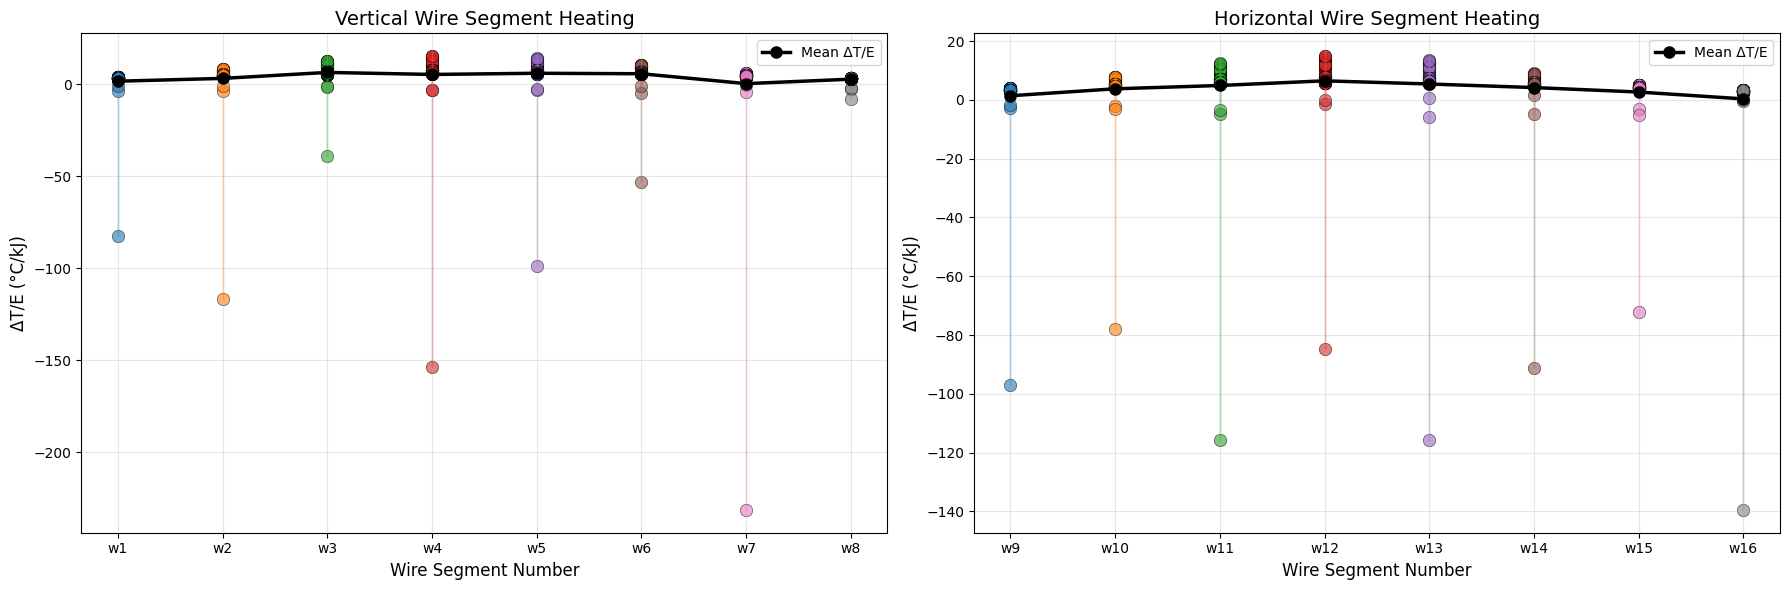



AVERAGE SEGMENT HEATING PER SHOT (across all wire segments)

Shots ranked by Average Segment ΔT (Highest to Lowest):
 Rank       Shot    Avg_ΔT   Std_ΔT    Max_ΔT   Avg_ΔT/E    Beam_E    Beam_V  Beam_On  Beam_Off
    1 113280.txt 20.459185 6.403014 28.434756   5.688357  3.596677 20.477166 0.465590  0.470810
    2 113284.txt 20.416410 6.349921 28.394404   5.685265  3.591109 20.523410 0.465594  0.470814
    3 113281.txt 20.069593 6.237476 27.764543   5.628741  3.565556 20.554947 0.465601  0.470801
    4 113276.txt 19.514472 6.060833 27.053294   5.501741  3.546963 20.598182 0.460625  0.465805
    5 113279.txt 19.481556 6.025722 27.024148   5.508876  3.536394 20.547758 0.460620  0.465800
    6 113277.txt 19.447505 6.005685 26.779146   5.497481  3.537531 20.449535 0.460596  0.465816
    7 113278.txt 19.244898 5.973845 26.763195   5.479610  3.512093 20.627602 0.460645  0.465805
    8 113285.txt 18.427333 5.908102 25.969083   5.605792  3.287196 20.608744 0.465597  0.470817
    9 113283.txt 

In [95]:
#SEGMENT ANALYSIS CONTINUED FROM CELL 1 (CHANGE CELL 1 SHOT LIST TO SEE CHANGES HERE)

print("\n" + "="*100)
print("SEGMENT-BY-SEGMENT ANALYSIS")
print("="*100)

# Define segment mappings: (name, high_ch, low_ch, label)
segment_mappings = [
    ('w1', 0, 1, '1-14'),     # w1 = ch0 - ch1
    ('w2', 1, 2, '14-2'),     # w2 = ch1 - ch2
    ('w3', 2, 3, '2-15'),
    ('w4', 3, 4, '15-3'),
    ('w5', 4, 5, '3-16'),
    ('w6', 5, 6, '16-4'),
    ('w7', 6, 7, '4-17'),
    ('w8', 7, np.nan, '17-5'),     # to center tap
    ('w9', 8, np.nan, '5-18'),
    ('w10', 9, 8, '18-6'),
    ('w11', 10, 9, '6-19'),
    ('w12', 11, 10, '19-7'),
    ('w13', 12, 11, '7-20'),
    ('w14', 13, 12, '20-8'),
    ('w15', 14, 13, '8-21'),
    ('w16', 15, 14, '21-9')
]

segment_results = []

for shot_file, df in datasets.items():
    shot_num = int(Path(shot_file).stem)
    beam_E = beam_energies[shot_file]
    
    channel_cols = [c for c in df.columns if c not in ["Time (s)", "Comment"]]
    
    # Get voltage averages before and after heating
    v1_start, v1_end = 0, 2000      # first 2 seconds
    v2_start, v2_end = 1800, 3800    # 2 seconds starting at t=1.8s
    
    ch_v1 = {}
    ch_v2 = {}
    
    for idx, col in enumerate(channel_cols):
        y = df[col].values
        ch_v1[idx] = np.mean(y[v1_start:v1_end])
        ch_v2[idx] = np.mean(y[v2_start:v2_end])
    
    # Calculate heating for each segment
    for wire, ch_high, ch_low, phys_label in segment_mappings:
        
        if ch_high not in ch_v1:
            continue
        
        if not np.isnan(ch_low) and ch_low not in ch_v1:
            continue
        
        # Voltage across this segment before and after
        if np.isnan(ch_low):
            V1 = ch_v1[ch_high]
            V2 = ch_v2[ch_high]
        else:
            V1 = ch_v1[ch_high] - ch_v1[ch_low]
            V2 = ch_v2[ch_high] - ch_v2[ch_low]
        dV = V2 - V1
        if wire == 'w16':
            a = 1
        # Convert to resistance and temperature
        dR = dV / WIRE_CURRENT
        R1 = V1 / WIRE_CURRENT
        
        dT = dR / (R1 * TCR) if abs(R1) > 0.01 else np.nan  # Allow negative R1
        dT_norm = dT / beam_E if (not np.isnan(dT) and beam_E > 0) else np.nan
        
        segment_results.append({
            'Shot': shot_file,
            'Wire_Name': wire,
            'Wire_Label': f'{wire} ({phys_label})',
            'Ch_High': ch_high,
            'Ch_Low': ch_low,
            'V_seg_1 (V)': V1,
            'V_seg_2 (V)': V2,
            'ΔV_seg (V)': dV,
            'R_seg_1 (Ω)': R1,
            'ΔR_seg (Ω)': dR,
            'ΔT_seg (°C)': dT,
            'Beam Energy (kJ)': beam_E,
            'ΔT_seg/E (°C/kJ)': dT_norm
        })

segment_df = pd.DataFrame(segment_results)

# Print results for each shot
for shot_file in segment_df['Shot'].unique():
    shot_data = segment_df[segment_df['Shot'] == shot_file]
    energy = shot_data['Beam Energy (kJ)'].iloc[0]
    
    print(f"\n{'='*100}")
    print(f"Shot: {shot_file} | Beam Energy: {energy:.2f} kJ")
    print(f"{'='*100}")
    print(shot_data[['Wire_Label', 'V_seg_1 (V)', 'V_seg_2 (V)', 'ΔV_seg (V)', 
                     'ΔT_seg (°C)', 'ΔT_seg/E (°C/kJ)']].to_string(index=False))

# Calculate stats for plotting
seg_stats = segment_df.groupby(['Wire_Name', 'Wire_Label']).agg({
    'ΔT_seg (°C)': ['mean', 'std', 'min', 'max'],
    'ΔT_seg/E (°C/kJ)': ['mean', 'std', 'min', 'max']
}).reset_index()

seg_stats.columns = ['Wire_Name', 'Wire_Label', 'ΔT_mean', 'ΔT_std', 'ΔT_min', 'ΔT_max',
                     'ΔT/E_mean', 'ΔT/E_std', 'ΔT/E_min', 'ΔT/E_max']

seg_stats['sort_key'] = seg_stats['Wire_Name'].str.extract('(\d+)').astype(int)
seg_stats = seg_stats.sort_values('sort_key').drop('sort_key', axis=1)

# PLOTS: SEGMENT HEATING PROFILES
print("\n\nCreating segment heating plots (normalized by beam energy)...")

all_wires = sorted(segment_df['Wire_Name'].unique(), key=lambda x: int(x[1:]))
vert_wires = [w for w in all_wires if w in ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8']]
horiz_wires = [w for w in all_wires if w in ['w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Vertical wires
for wire in vert_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    wire_num = int(wire[1:])
    x = np.full(len(data), wire_num)
    y = data['ΔT_seg/E (°C/kJ)'].values
    
    ax1.scatter(x, y, s=80, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax1.plot(x, y, alpha=0.3, linewidth=1)

# Mean line for vertical
vert_means, vert_x = [], []
for wire in vert_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    vert_means.append(data['ΔT_seg/E (°C/kJ)'].mean())
    vert_x.append(int(wire[1:]))
ax1.plot(vert_x, vert_means, 'k-', linewidth=2.5, marker='o', markersize=8, label='Mean ΔT/E')

ax1.set_xlabel('Wire Segment Number', fontsize=12)
ax1.set_ylabel('ΔT/E (°C/kJ)', fontsize=12)
ax1.set_title('Vertical Wire Segment Heating', fontsize=14)
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
ax1.set_xticklabels(['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8'])
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best', fontsize=10)

# Horizontal wires
for wire in horiz_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    wire_num = int(wire[1:])
    x = np.full(len(data), wire_num)
    y = data['ΔT_seg/E (°C/kJ)'].values
    
    ax2.scatter(x, y, s=80, alpha=0.6, edgecolor='black', linewidth=0.5)
    ax2.plot(x, y, alpha=0.3, linewidth=1)

# Mean line for horizontal
horiz_means, horiz_x = [], []
for wire in horiz_wires:
    data = segment_df[segment_df['Wire_Name'] == wire]
    horiz_means.append(data['ΔT_seg/E (°C/kJ)'].mean())
    horiz_x.append(int(wire[1:]))
ax2.plot(horiz_x, horiz_means, 'k-', linewidth=2.5, marker='o', markersize=8, label='Mean ΔT/E')

ax2.set_xlabel('Wire Segment Number', fontsize=12)
ax2.set_ylabel('ΔT/E (°C/kJ)', fontsize=12)
ax2.set_title('Horizontal Wire Segment Heating', fontsize=14)
ax2.set_xticks([9, 10, 11, 12, 13, 14, 15, 16])
ax2.set_xticklabels(['w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16'])
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

# AVG SEGMENT HEATING PER SHOT
print("\n\n" + "="*100)
print("AVERAGE SEGMENT HEATING PER SHOT (across all wire segments)")
print("="*100)

# Average all segments for each shot
shot_avg = segment_df.groupby('Shot').agg({
    'ΔT_seg (°C)': ['mean', 'std', 'min', 'max'],
    'ΔT_seg/E (°C/kJ)': ['mean', 'std', 'min', 'max'],
    'Beam Energy (kJ)': 'first'
}).reset_index()

shot_avg.columns = ['Shot', 'Avg_ΔT', 'Std_ΔT', 'Min_ΔT', 'Max_ΔT',
                    'Avg_ΔT/E', 'Std_ΔT/E', 'Min_ΔT/E', 'Max_ΔT/E', 'Beam_E']

# Add beam timing information
shot_avg['Beam_On'] = shot_avg['Shot'].map(lambda x: beam_timings[x][0])
shot_avg['Beam_Off'] = shot_avg['Shot'].map(lambda x: beam_timings[x][1])

# Add beam voltage information
shot_avg['Beam_V'] = shot_avg['Shot'].map(lambda x: beam_voltages[x])

# Rank by raw heating
by_temp = shot_avg.sort_values('Avg_ΔT', ascending=False).reset_index(drop=True)
by_temp['Rank'] = by_temp.index + 1

print("\nShots ranked by Average Segment ΔT (Highest to Lowest):")
print(by_temp[['Rank', 'Shot', 'Avg_ΔT', 'Std_ΔT', 'Max_ΔT', 'Avg_ΔT/E', 'Beam_E', 'Beam_V', 'Beam_On', 'Beam_Off']].to_string(index=False))

# Rank by normalized heating
by_norm = shot_avg.sort_values('Avg_ΔT/E', ascending=False).reset_index(drop=True)
by_norm['Rank'] = by_norm.index + 1

print("\n\nShots ranked by Average Segment ΔT/E (Highest to Lowest):")
print(by_norm[['Rank', 'Shot', 'Avg_ΔT/E', 'Std_ΔT/E', 'Max_ΔT/E', 'Avg_ΔT', 'Beam_E', 'Beam_V', 'Beam_On', 'Beam_Off']].to_string(index=False))

print("\n" + "="*100)
print("Segment-by-segment analysis complete!")
print("="*100)


2D GAUSSIAN BEAM PROFILE FITTING


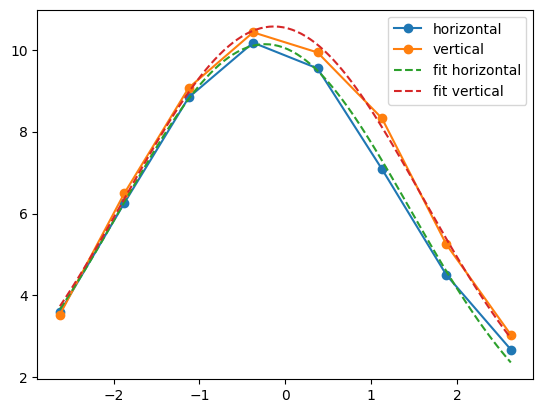

Shot 112560.txt:
  Gaussian center: (x0, y0) = (-0.133, -0.234) in
  Widths (sigma_x, sigma_y) = (1.729, 1.676) in
  Amplitude A = 2.427, A_h = 10.134, A_v = 10.567, Delta_A = -0.433


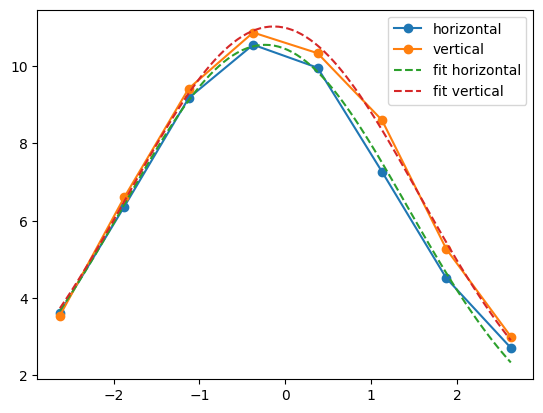

Shot 112561.txt:
  Gaussian center: (x0, y0) = (-0.136, -0.234) in
  Widths (sigma_x, sigma_y) = (1.692, 1.647) in
  Amplitude A = 2.578, A_h = 10.546, A_v = 11.020, Delta_A = -0.474


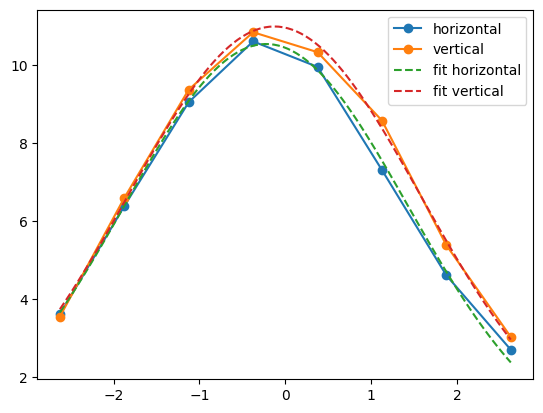

Shot 112562.txt:
  Gaussian center: (x0, y0) = (-0.128, -0.224) in
  Widths (sigma_x, sigma_y) = (1.702, 1.652) in
  Amplitude A = 2.561, A_h = 10.538, A_v = 10.987, Delta_A = -0.449


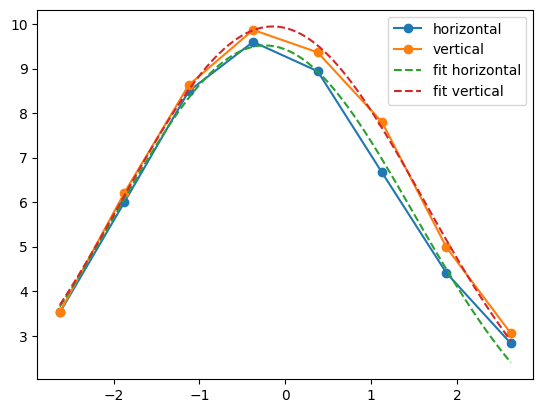

Shot 112696.txt:
  Gaussian center: (x0, y0) = (-0.146, -0.239) in
  Widths (sigma_x, sigma_y) = (1.761, 1.725) in
  Amplitude A = 2.228, A_h = 9.518, A_v = 9.944, Delta_A = -0.426


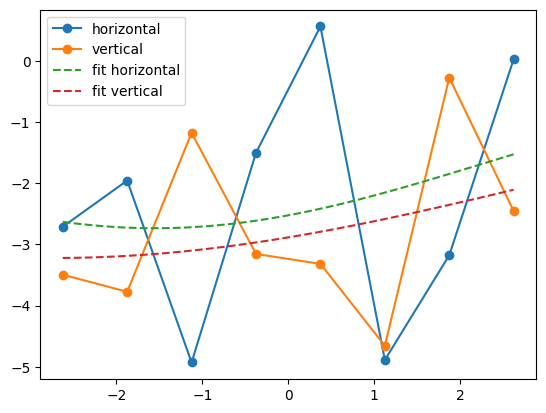

Shot 112697.txt:
  Gaussian center: (x0, y0) = (-2.731, -1.549) in
  Widths (sigma_x, sigma_y) = (5.811, -3.866) in
  Amplitude A = 0.072, A_h = -2.734, A_v = -3.221, Delta_A = 0.487


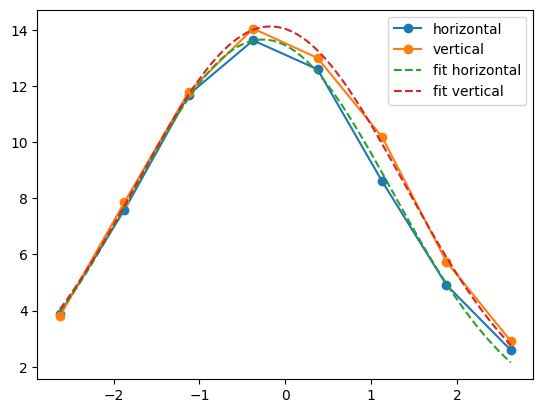

Shot 112698.txt:
  Gaussian center: (x0, y0) = (-0.173, -0.262) in
  Widths (sigma_x, sigma_y) = (1.551, 1.502) in
  Amplitude A = 3.633, A_h = 13.657, A_v = 14.123, Delta_A = -0.466


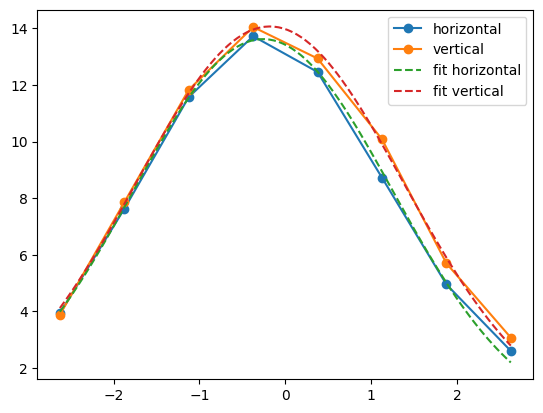

Shot 112699.txt:
  Gaussian center: (x0, y0) = (-0.180, -0.259) in
  Widths (sigma_x, sigma_y) = (1.559, 1.509) in
  Amplitude A = 3.600, A_h = 13.618, A_v = 14.064, Delta_A = -0.447


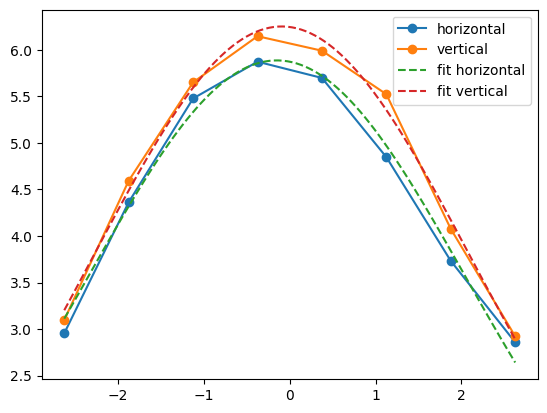

Shot 112708.txt:
  Gaussian center: (x0, y0) = (-0.093, -0.150) in
  Widths (sigma_x, sigma_y) = (2.189, 2.192) in
  Amplitude A = 1.105, A_h = 5.887, A_v = 6.251, Delta_A = -0.365


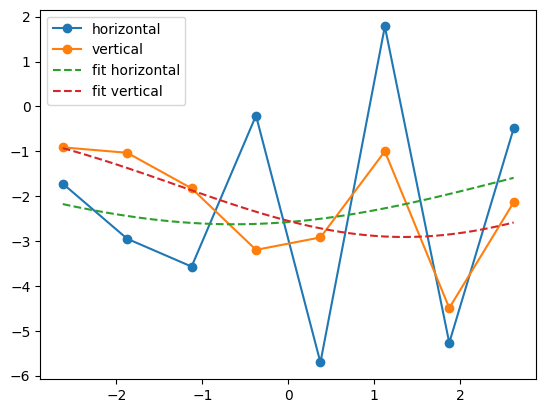

Shot 112709.txt:
  Gaussian center: (x0, y0) = (1.349, -0.631) in
  Widths (sigma_x, sigma_y) = (2.631, -3.254) in
  Amplitude A = -0.021, A_h = -2.627, A_v = -2.911, Delta_A = 0.284


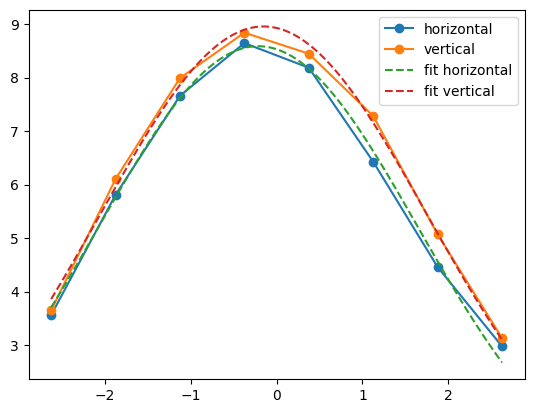

Shot 112712.txt:
  Gaussian center: (x0, y0) = (-0.152, -0.214) in
  Widths (sigma_x, sigma_y) = (1.906, 1.859) in
  Amplitude A = 1.860, A_h = 8.587, A_v = 8.956, Delta_A = -0.369


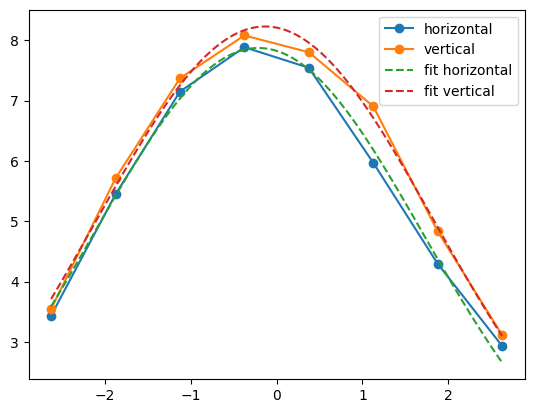

Shot 112713.txt:
  Gaussian center: (x0, y0) = (-0.134, -0.212) in
  Widths (sigma_x, sigma_y) = (1.974, 1.925) in
  Amplitude A = 1.649, A_h = 7.874, A_v = 8.231, Delta_A = -0.357


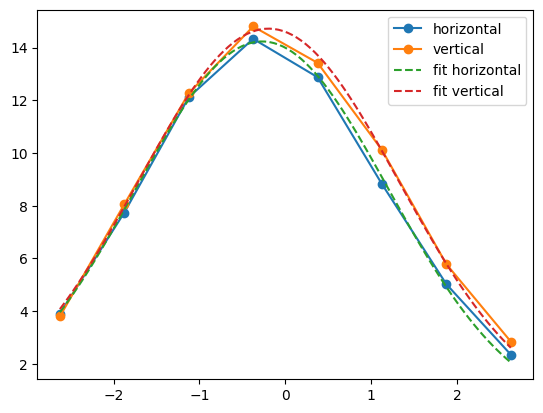

Shot 112714.txt:
  Gaussian center: (x0, y0) = (-0.195, -0.271) in
  Widths (sigma_x, sigma_y) = (1.517, 1.472) in
  Amplitude A = 3.867, A_h = 14.234, A_v = 14.719, Delta_A = -0.486


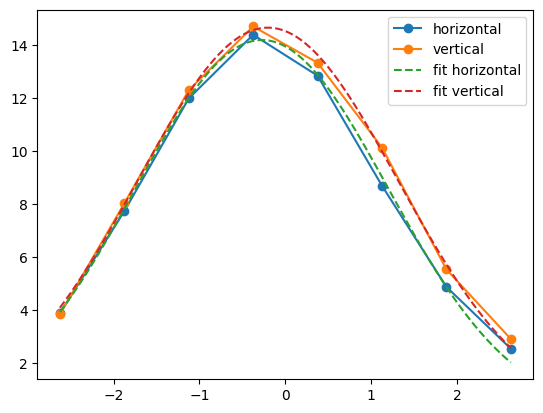

Shot 112715.txt:
  Gaussian center: (x0, y0) = (-0.203, -0.272) in
  Widths (sigma_x, sigma_y) = (1.516, 1.469) in
  Amplitude A = 3.862, A_h = 14.207, A_v = 14.674, Delta_A = -0.467


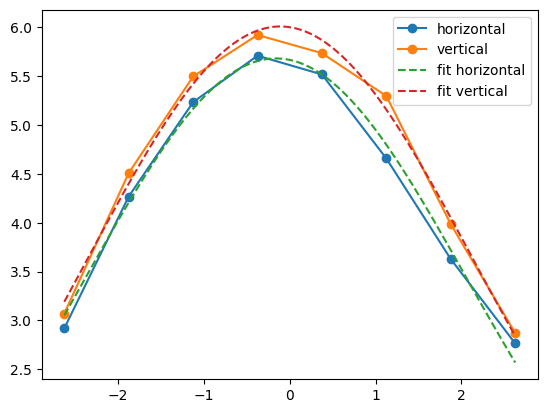

Shot 112716.txt:
  Gaussian center: (x0, y0) = (-0.110, -0.160) in
  Widths (sigma_x, sigma_y) = (2.235, 2.211) in
  Amplitude A = 1.049, A_h = 5.681, A_v = 6.008, Delta_A = -0.327


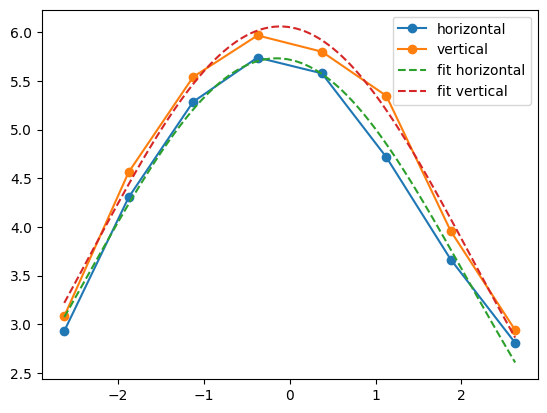

Shot 112717.txt:
  Gaussian center: (x0, y0) = (-0.112, -0.153) in
  Widths (sigma_x, sigma_y) = (2.234, 2.213) in
  Amplitude A = 1.058, A_h = 5.733, A_v = 6.060, Delta_A = -0.328


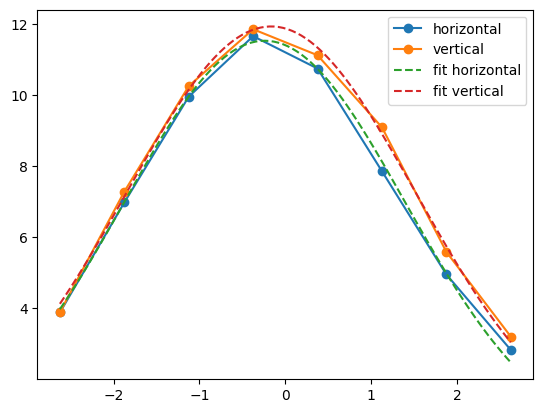

Shot 112718.txt:
  Gaussian center: (x0, y0) = (-0.165, -0.241) in
  Widths (sigma_x, sigma_y) = (1.688, 1.634) in
  Amplitude A = 2.819, A_h = 11.526, A_v = 11.928, Delta_A = -0.402


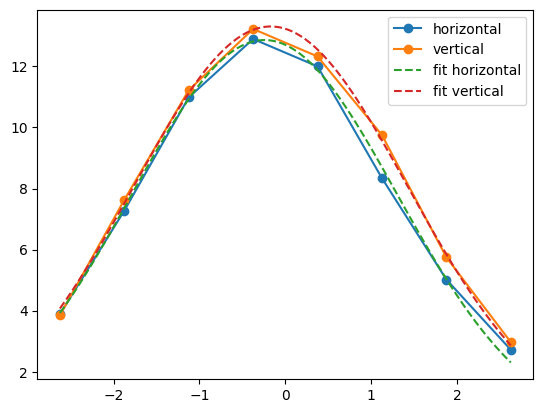

Shot 112719.txt:
  Gaussian center: (x0, y0) = (-0.170, -0.243) in
  Widths (sigma_x, sigma_y) = (1.595, 1.546) in
  Amplitude A = 3.327, A_h = 12.865, A_v = 13.309, Delta_A = -0.444


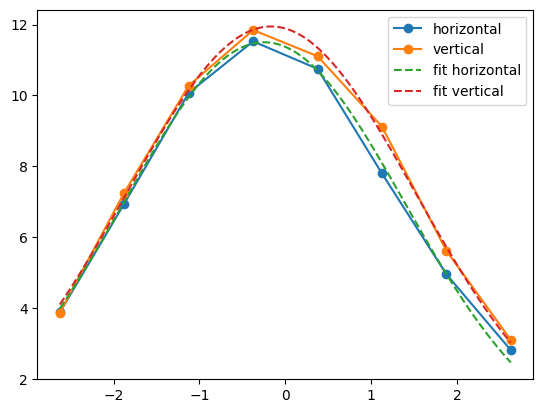

Shot 112720.txt:
  Gaussian center: (x0, y0) = (-0.165, -0.246) in
  Widths (sigma_x, sigma_y) = (1.682, 1.635) in
  Amplitude A = 2.822, A_h = 11.503, A_v = 11.948, Delta_A = -0.446


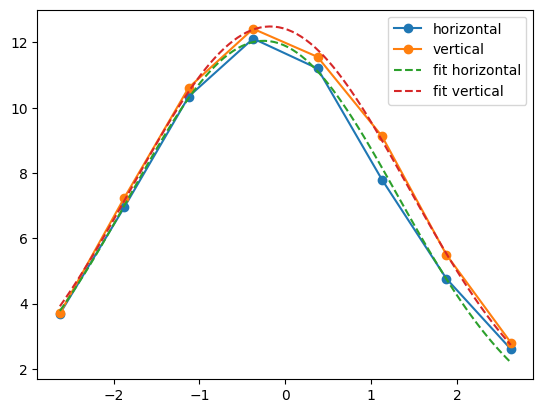

Shot 112721.txt:
  Gaussian center: (x0, y0) = (-0.177, -0.251) in
  Widths (sigma_x, sigma_y) = (1.608, 1.559) in
  Amplitude A = 3.093, A_h = 12.049, A_v = 12.489, Delta_A = -0.439


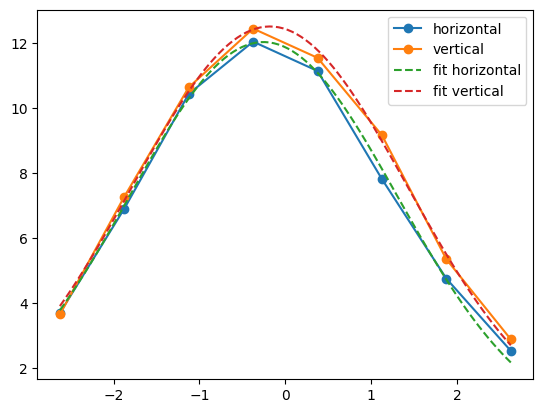

Shot 112722.txt:
  Gaussian center: (x0, y0) = (-0.180, -0.255) in
  Widths (sigma_x, sigma_y) = (1.604, 1.559) in
  Amplitude A = 3.096, A_h = 12.026, A_v = 12.504, Delta_A = -0.478


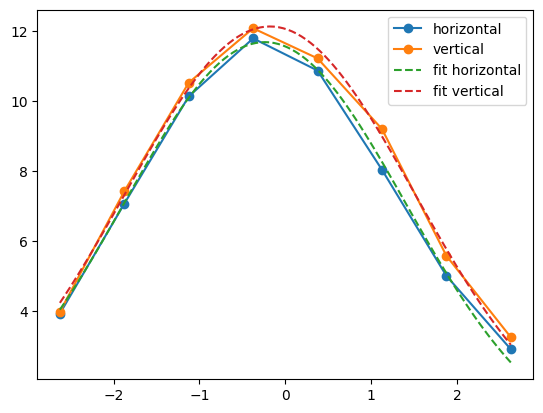

Shot 112724.txt:
  Gaussian center: (x0, y0) = (-0.180, -0.238) in
  Widths (sigma_x, sigma_y) = (1.687, 1.639) in
  Amplitude A = 2.859, A_h = 11.687, A_v = 12.134, Delta_A = -0.447


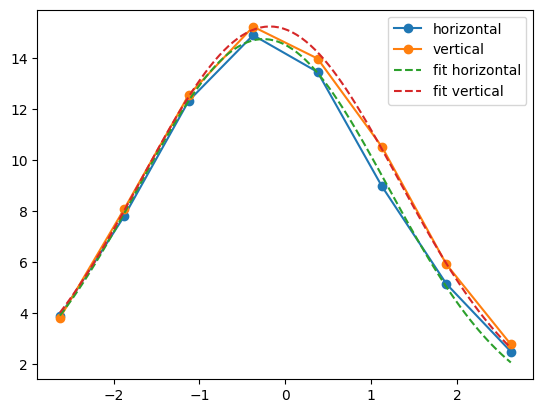

Shot 112725.txt:
  Gaussian center: (x0, y0) = (-0.180, -0.256) in
  Widths (sigma_x, sigma_y) = (1.497, 1.453) in
  Amplitude A = 4.060, A_h = 14.756, A_v = 15.251, Delta_A = -0.495


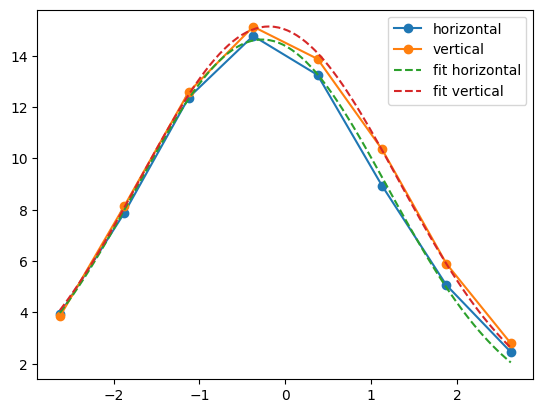

Shot 112726.txt:
  Gaussian center: (x0, y0) = (-0.191, -0.270) in
  Widths (sigma_x, sigma_y) = (1.504, 1.460) in
  Amplitude A = 4.011, A_h = 14.636, A_v = 15.145, Delta_A = -0.509


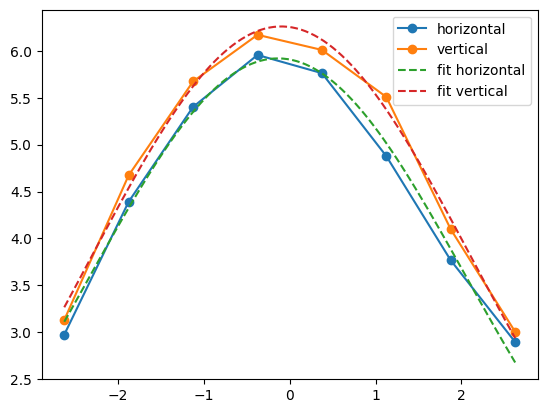

Shot 112727.txt:
  Gaussian center: (x0, y0) = (-0.099, -0.138) in
  Widths (sigma_x, sigma_y) = (2.215, 2.194) in
  Amplitude A = 1.102, A_h = 5.919, A_v = 6.260, Delta_A = -0.340


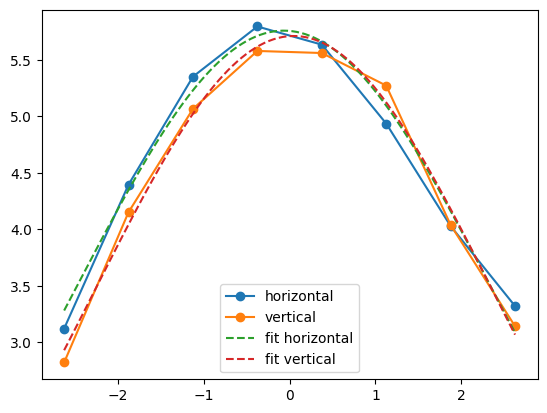

Shot 113260.txt:
  Gaussian center: (x0, y0) = (0.047, -0.068) in
  Widths (sigma_x, sigma_y) = (2.312, 2.410) in
  Amplitude A = 0.970, A_h = 5.760, A_v = 5.713, Delta_A = 0.047


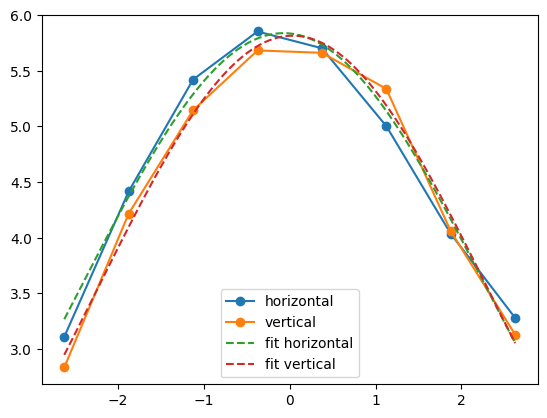

Shot 113261.txt:
  Gaussian center: (x0, y0) = (0.035, -0.072) in
  Widths (sigma_x, sigma_y) = (2.282, 2.370) in
  Amplitude A = 1.000, A_h = 5.838, A_v = 5.815, Delta_A = 0.023


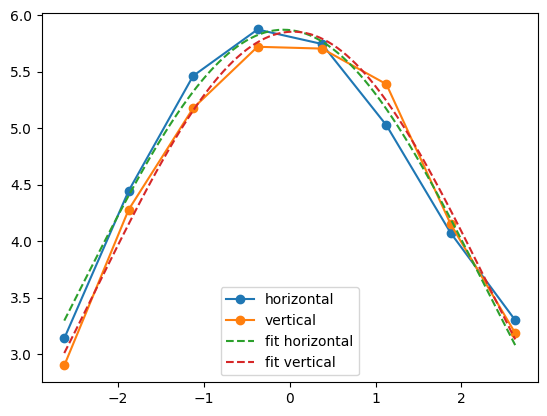

Shot 113262.txt:
  Gaussian center: (x0, y0) = (0.040, -0.073) in
  Widths (sigma_x, sigma_y) = (2.309, 2.374) in
  Amplitude A = 0.999, A_h = 5.871, A_v = 5.854, Delta_A = 0.017


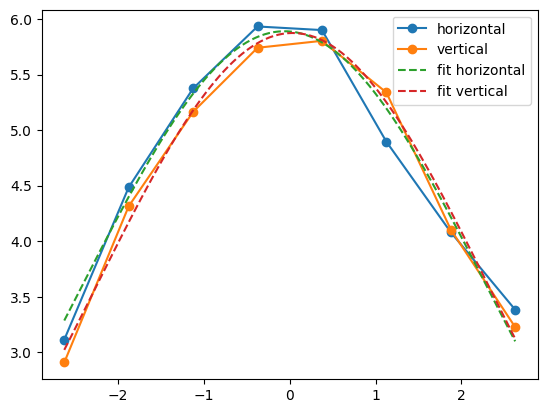

Shot 113263.txt:
  Gaussian center: (x0, y0) = (0.033, -0.063) in
  Widths (sigma_x, sigma_y) = (2.305, 2.371) in
  Amplitude A = 1.004, A_h = 5.891, A_v = 5.875, Delta_A = 0.016


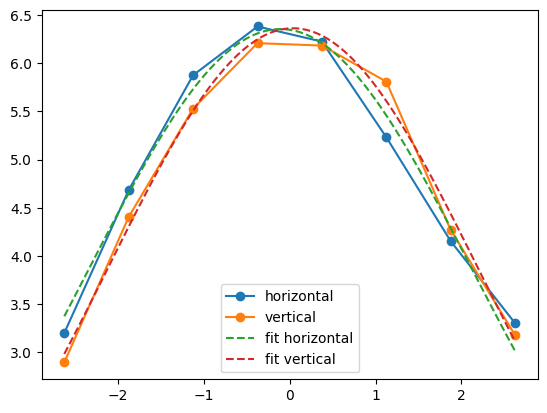

Shot 113264.txt:
  Gaussian center: (x0, y0) = (0.038, -0.108) in
  Widths (sigma_x, sigma_y) = (2.162, 2.235) in
  Amplitude A = 1.154, A_h = 6.355, A_v = 6.364, Delta_A = -0.008


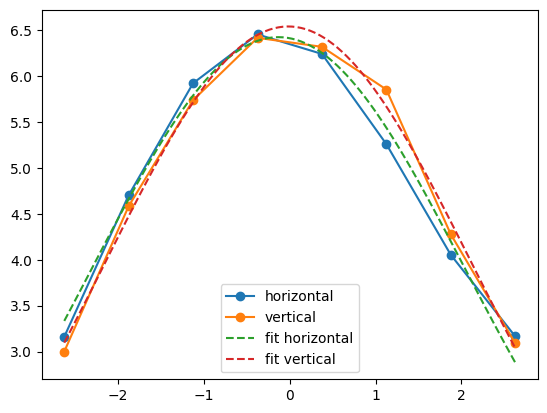

Shot 113268.txt:
  Gaussian center: (x0, y0) = (-0.016, -0.132) in
  Widths (sigma_x, sigma_y) = (2.133, 2.177) in
  Amplitude A = 1.200, A_h = 6.424, A_v = 6.540, Delta_A = -0.116


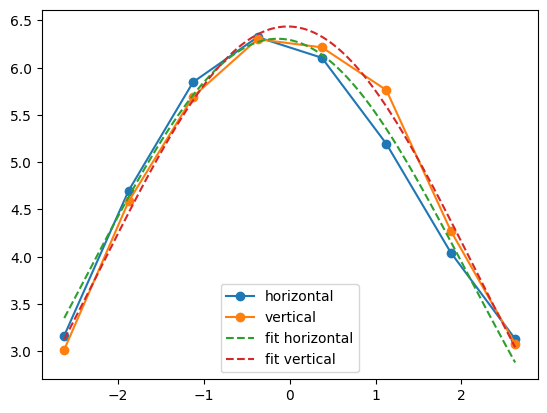

Shot 113269.txt:
  Gaussian center: (x0, y0) = (-0.024, -0.141) in
  Widths (sigma_x, sigma_y) = (2.165, 2.210) in
  Amplitude A = 1.162, A_h = 6.306, A_v = 6.436, Delta_A = -0.130


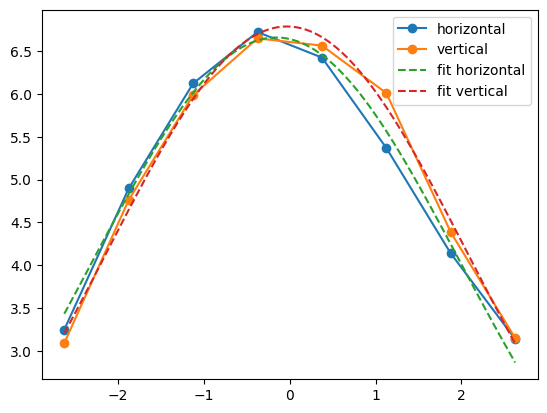

Shot 113270.txt:
  Gaussian center: (x0, y0) = (-0.033, -0.158) in
  Widths (sigma_x, sigma_y) = (2.116, 2.143) in
  Amplitude A = 1.260, A_h = 6.658, A_v = 6.787, Delta_A = -0.129


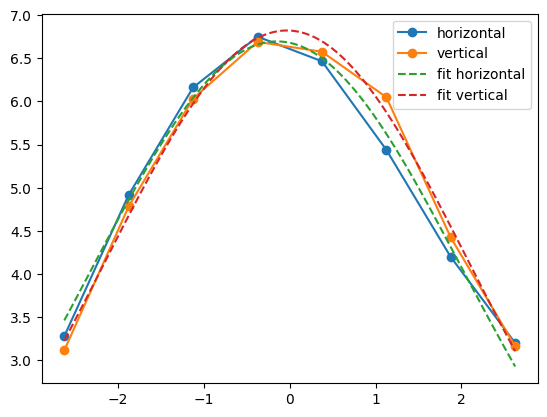

Shot 113271.txt:
  Gaussian center: (x0, y0) = (-0.033, -0.148) in
  Widths (sigma_x, sigma_y) = (2.120, 2.157) in
  Amplitude A = 1.261, A_h = 6.696, A_v = 6.822, Delta_A = -0.127


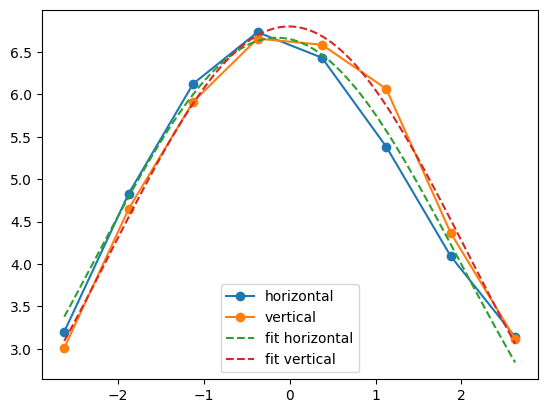

Shot 113273.txt:
  Gaussian center: (x0, y0) = (-0.009, -0.149) in
  Widths (sigma_x, sigma_y) = (2.084, 2.123) in
  Amplitude A = 1.277, A_h = 6.666, A_v = 6.799, Delta_A = -0.133


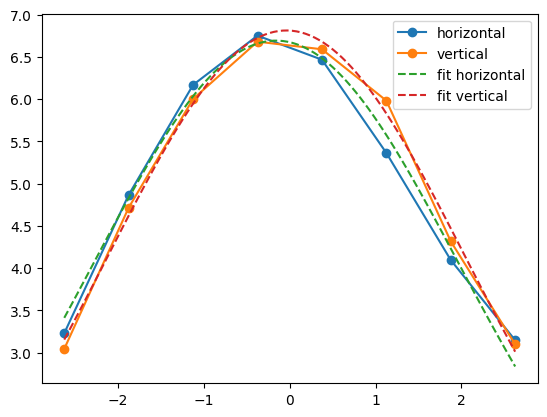

Shot 113274.txt:
  Gaussian center: (x0, y0) = (-0.038, -0.159) in
  Widths (sigma_x, sigma_y) = (2.084, 2.124) in
  Amplitude A = 1.281, A_h = 6.694, A_v = 6.814, Delta_A = -0.120


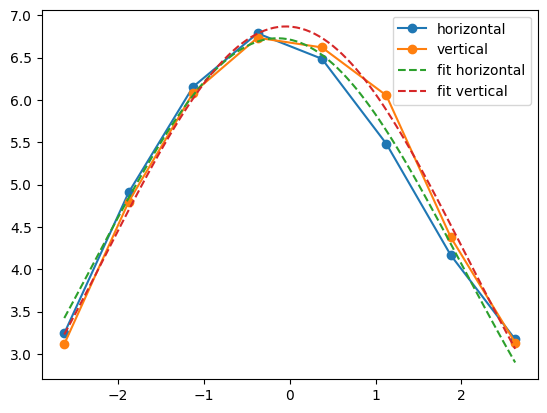

Shot 113275.txt:
  Gaussian center: (x0, y0) = (-0.045, -0.144) in
  Widths (sigma_x, sigma_y) = (2.100, 2.134) in
  Amplitude A = 1.281, A_h = 6.729, A_v = 6.868, Delta_A = -0.139


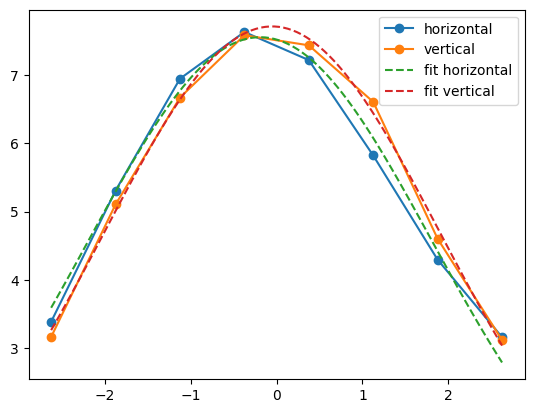

Shot 113276.txt:
  Gaussian center: (x0, y0) = (-0.052, -0.191) in
  Widths (sigma_x, sigma_y) = (1.962, 1.996) in
  Amplitude A = 1.538, A_h = 7.551, A_v = 7.708, Delta_A = -0.158


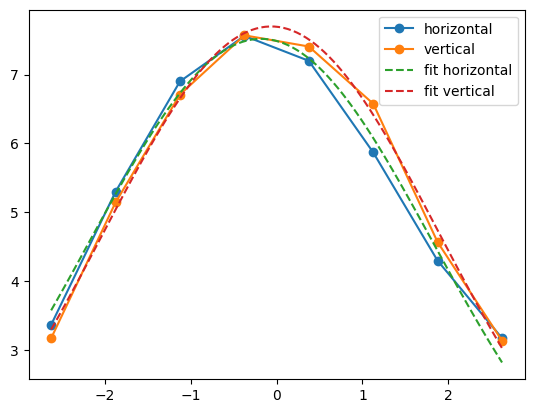

Shot 113277.txt:
  Gaussian center: (x0, y0) = (-0.063, -0.182) in
  Widths (sigma_x, sigma_y) = (1.968, 2.004) in
  Amplitude A = 1.528, A_h = 7.519, A_v = 7.699, Delta_A = -0.180


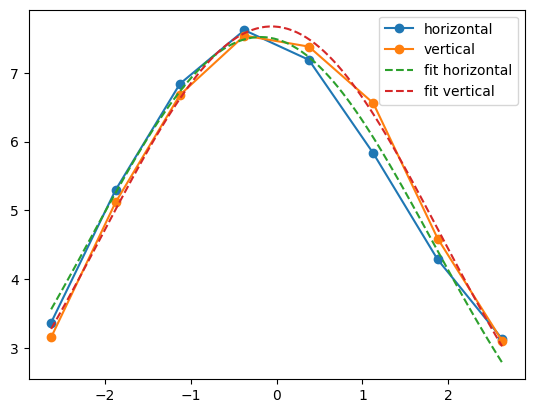

Shot 113278.txt:
  Gaussian center: (x0, y0) = (-0.059, -0.186) in
  Widths (sigma_x, sigma_y) = (1.966, 1.994) in
  Amplitude A = 1.531, A_h = 7.520, A_v = 7.674, Delta_A = -0.154


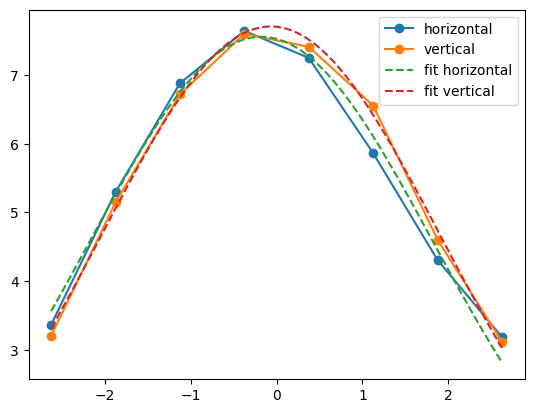

Shot 113279.txt:
  Gaussian center: (x0, y0) = (-0.067, -0.178) in
  Widths (sigma_x, sigma_y) = (1.970, 1.996) in
  Amplitude A = 1.535, A_h = 7.556, A_v = 7.706, Delta_A = -0.150


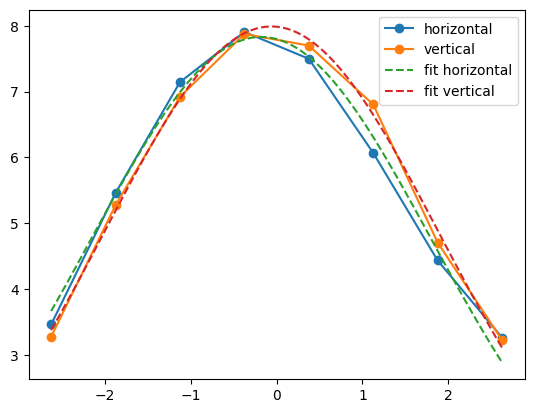

Shot 113280.txt:
  Gaussian center: (x0, y0) = (-0.060, -0.180) in
  Widths (sigma_x, sigma_y) = (1.954, 1.984) in
  Amplitude A = 1.602, A_h = 7.830, A_v = 7.990, Delta_A = -0.159


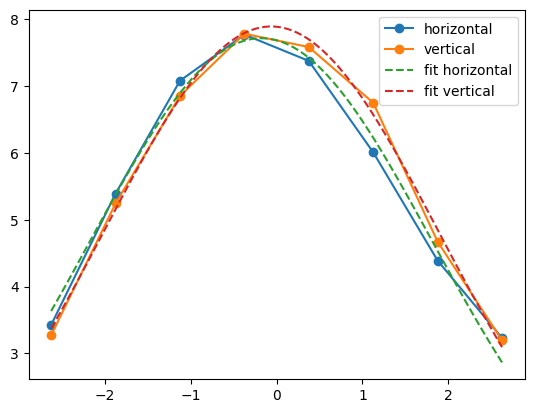

Shot 113281.txt:
  Gaussian center: (x0, y0) = (-0.063, -0.180) in
  Widths (sigma_x, sigma_y) = (1.964, 1.992) in
  Amplitude A = 1.575, A_h = 7.720, A_v = 7.896, Delta_A = -0.176


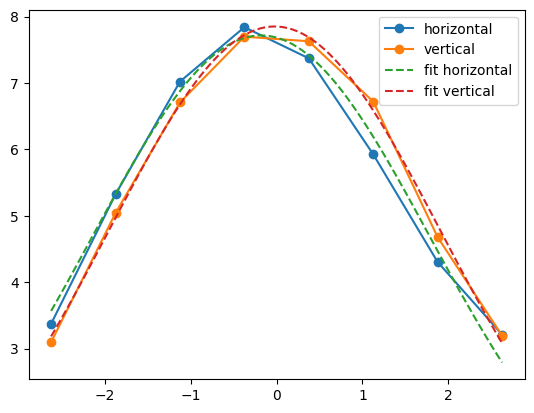

Shot 113282.txt:
  Gaussian center: (x0, y0) = (-0.023, -0.181) in
  Widths (sigma_x, sigma_y) = (1.936, 1.967) in
  Amplitude A = 1.591, A_h = 7.717, A_v = 7.852, Delta_A = -0.135


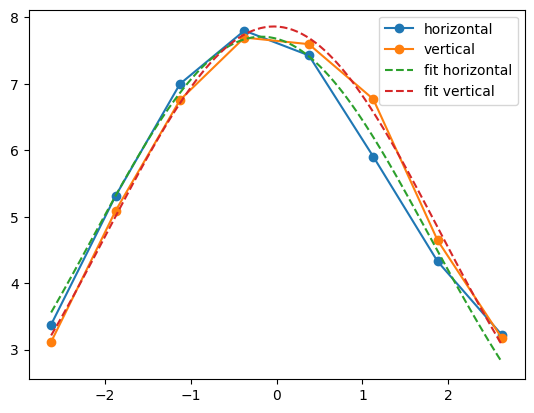

Shot 113283.txt:
  Gaussian center: (x0, y0) = (-0.033, -0.176) in
  Widths (sigma_x, sigma_y) = (1.937, 1.970) in
  Amplitude A = 1.591, A_h = 7.711, A_v = 7.864, Delta_A = -0.154


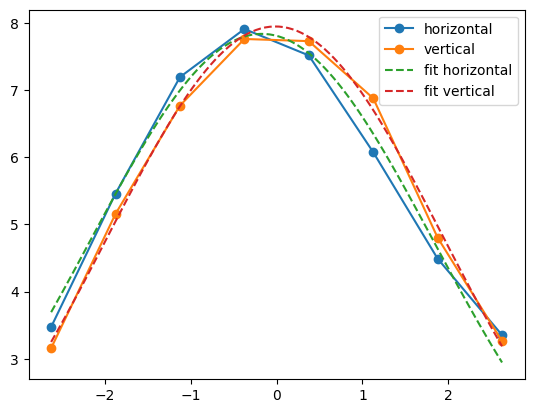

Shot 113284.txt:
  Gaussian center: (x0, y0) = (-0.015, -0.172) in
  Widths (sigma_x, sigma_y) = (1.952, 2.000) in
  Amplitude A = 1.593, A_h = 7.835, A_v = 7.945, Delta_A = -0.110


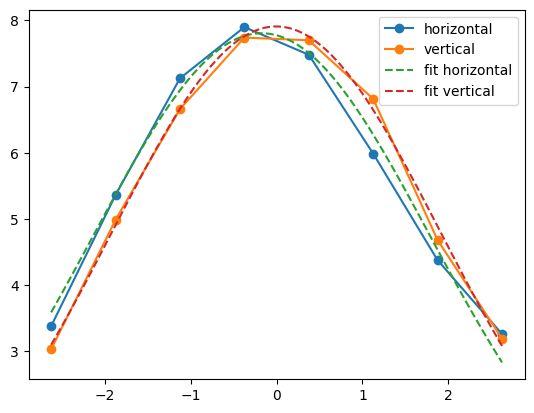

Shot 113285.txt:
  Gaussian center: (x0, y0) = (-0.004, -0.174) in
  Widths (sigma_x, sigma_y) = (1.915, 1.966) in
  Amplitude A = 1.616, A_h = 7.807, A_v = 7.910, Delta_A = -0.103


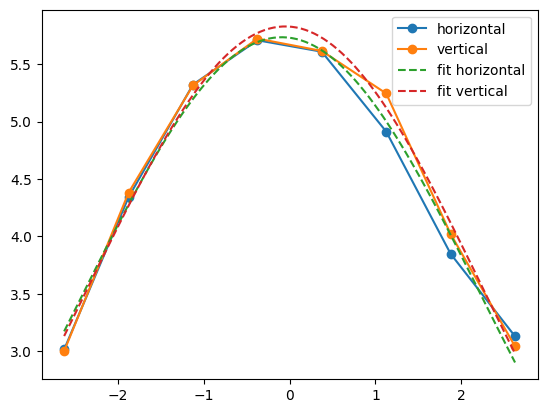

Shot 113297.txt:
  Gaussian center: (x0, y0) = (-0.051, -0.092) in
  Widths (sigma_x, sigma_y) = (2.310, 2.328) in
  Amplitude A = 0.995, A_h = 5.734, A_v = 5.828, Delta_A = -0.094


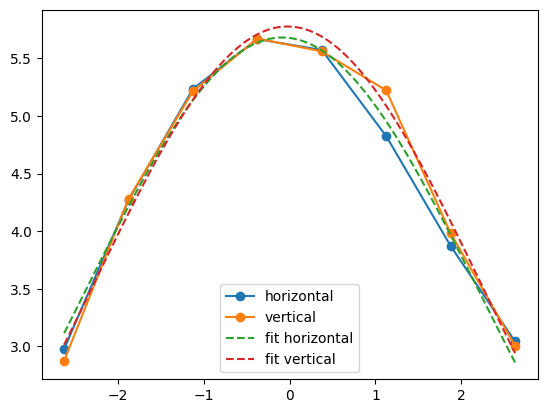

Shot 113298.txt:
  Gaussian center: (x0, y0) = (-0.025, -0.087) in
  Widths (sigma_x, sigma_y) = (2.280, 2.314) in
  Amplitude A = 0.995, A_h = 5.682, A_v = 5.777, Delta_A = -0.096


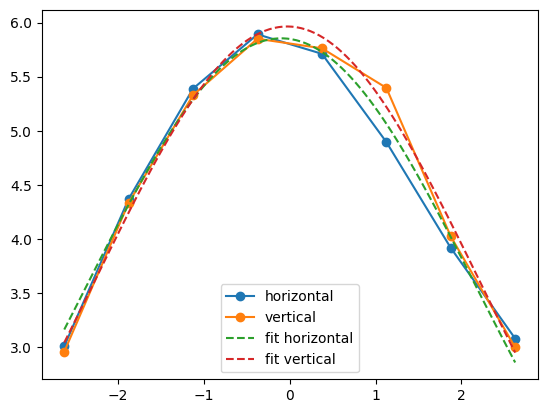

Shot 113299.txt:
  Gaussian center: (x0, y0) = (-0.030, -0.100) in
  Widths (sigma_x, sigma_y) = (2.238, 2.277) in
  Amplitude A = 1.044, A_h = 5.854, A_v = 5.964, Delta_A = -0.109


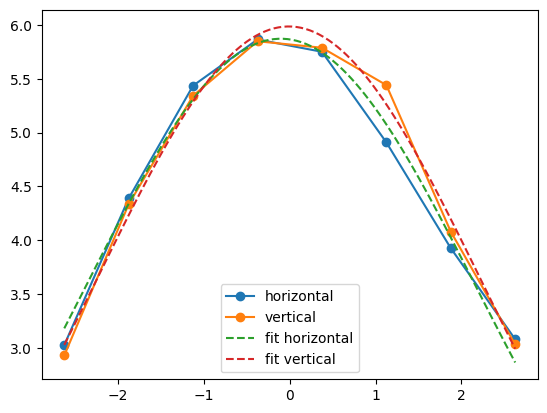

Shot 113300.txt:
  Gaussian center: (x0, y0) = (-0.011, -0.104) in
  Widths (sigma_x, sigma_y) = (2.237, 2.276) in
  Amplitude A = 1.048, A_h = 5.873, A_v = 5.987, Delta_A = -0.114


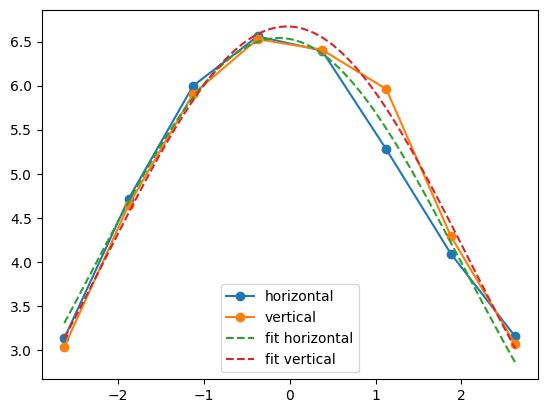

Shot 113301.txt:
  Gaussian center: (x0, y0) = (-0.032, -0.126) in
  Widths (sigma_x, sigma_y) = (2.110, 2.138) in
  Amplitude A = 1.241, A_h = 6.541, A_v = 6.671, Delta_A = -0.131


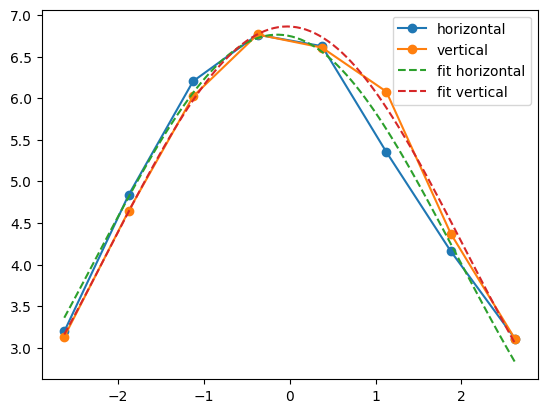

Shot 113302.txt:
  Gaussian center: (x0, y0) = (-0.030, -0.146) in
  Widths (sigma_x, sigma_y) = (2.084, 2.096) in
  Amplitude A = 1.300, A_h = 6.763, A_v = 6.862, Delta_A = -0.099


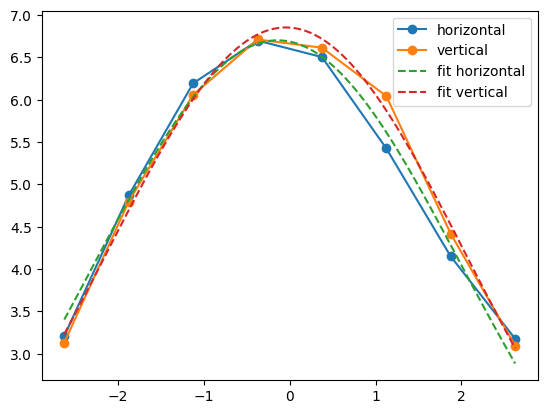

Shot 113303.txt:
  Gaussian center: (x0, y0) = (-0.045, -0.143) in
  Widths (sigma_x, sigma_y) = (2.104, 2.132) in
  Amplitude A = 1.277, A_h = 6.703, A_v = 6.855, Delta_A = -0.152


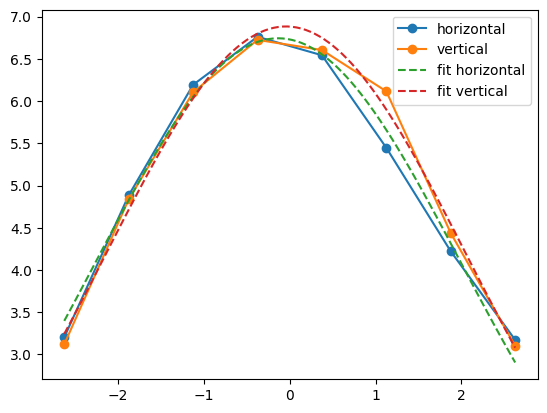

Shot 113304.txt:
  Gaussian center: (x0, y0) = (-0.044, -0.135) in
  Widths (sigma_x, sigma_y) = (2.104, 2.127) in
  Amplitude A = 1.285, A_h = 6.744, A_v = 6.884, Delta_A = -0.140


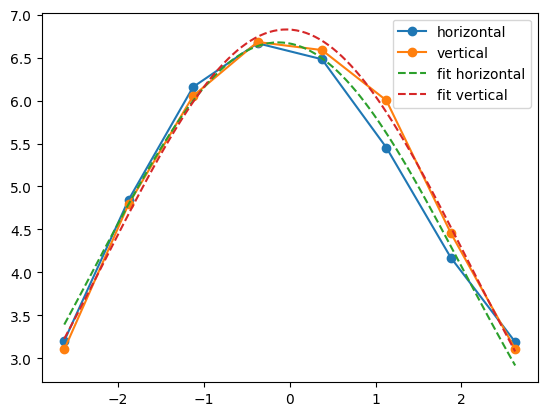

Shot 113305.txt:
  Gaussian center: (x0, y0) = (-0.040, -0.132) in
  Widths (sigma_x, sigma_y) = (2.112, 2.143) in
  Amplitude A = 1.266, A_h = 6.677, A_v = 6.827, Delta_A = -0.150


Successfully fit 55 shots

SUMMARY: BEAM PROFILE STATISTICS (across all shots)
Mean beam center:    x0 = -0.101 ± 0.415 in
                     y0 = -0.209 ± 0.203 in
Mean beam width:     σx = 2.043 ± 0.583 in
                     σy = 1.766 ± 1.084 in
Mean FWHM:           FWHMx = 4.811 ± 1.372 in
                     FWHMy = 4.159 ± 2.554 in
Mean aspect ratio:   σx/σy = 0.921 ± 0.413
Mean Delta_A (A_h - A_v):  -0.218 ± 0.204

Results saved to: /u/hgajani/shot_gaussian_fits.csv


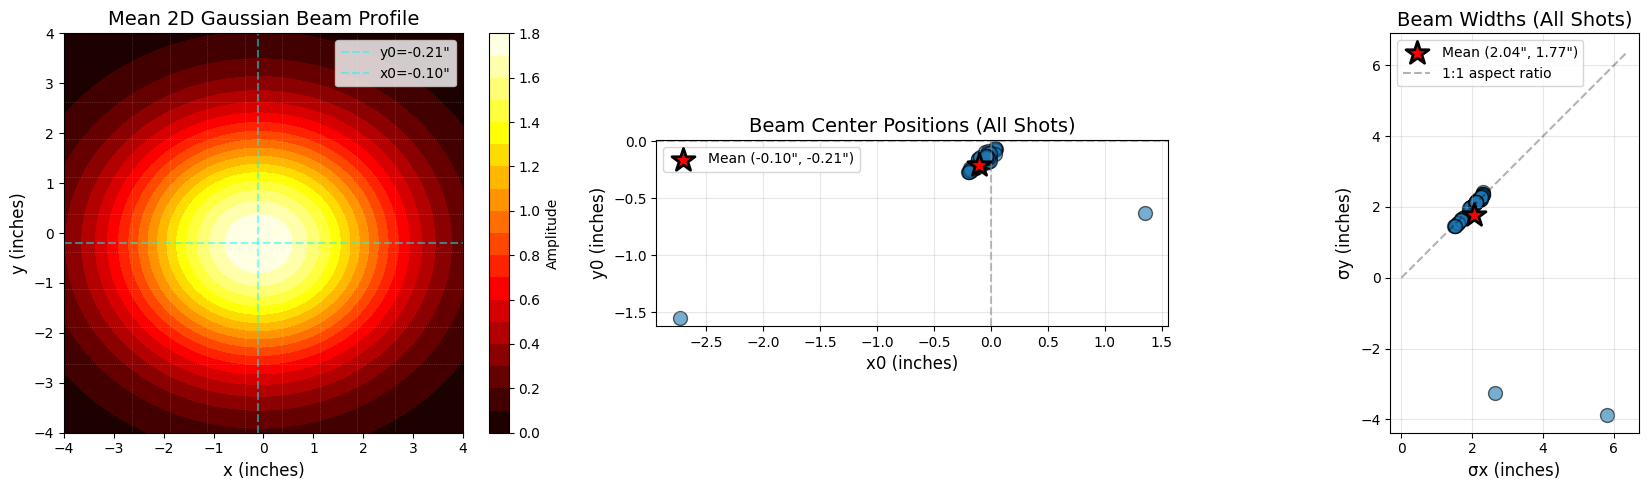


AMPLITUDE ASYMMETRY (A_h - A_v) VS BEAM VOLTAGE ANALYSIS

55 shots have valid beam voltage and amplitude asymmetry data

Per-shot amplitude asymmetry:
Shot 112560: V=12.31 kV | I=16.416 A | P=12.0 μA/V^1.5 | A_h=10.1340 | A_v=10.5667 | ΔA=-0.4327
Shot 112561: V=12.32 kV | I=17.552 A | P=12.8 μA/V^1.5 | A_h=10.5459 | A_v=11.0202 | ΔA=-0.4744
Shot 112562: V=12.33 kV | I=17.447 A | P=12.7 μA/V^1.5 | A_h=10.5379 | A_v=10.9871 | ΔA=-0.4492
Shot 112696: V=16.43 kV | I=25.856 A | P=12.3 μA/V^1.5 | A_h=9.5181 | A_v=9.9441 | ΔA=-0.4260
Shot 112697: V=12.69 kV | I=0.344 A | P=0.2 μA/V^1.5 | A_h=-2.7345 | A_v=-3.2210 | ΔA=0.4866
Shot 112698: V=12.22 kV | I=24.660 A | P=18.2 μA/V^1.5 | A_h=13.6573 | A_v=14.1228 | ΔA=-0.4655
Shot 112699: V=12.24 kV | I=24.572 A | P=18.1 μA/V^1.5 | A_h=13.6175 | A_v=14.0642 | ΔA=-0.4467
Shot 112708: V=20.61 kV | I=29.047 A | P=9.8 μA/V^1.5 | A_h=5.8867 | A_v=6.2514 | ΔA=-0.3647
Shot 112709: V=16.98 kV | I=0.244 A | P=0.1 μA/V^1.5 | A_h=-2.6272 | A_v=-2.9107 | ΔA=0.

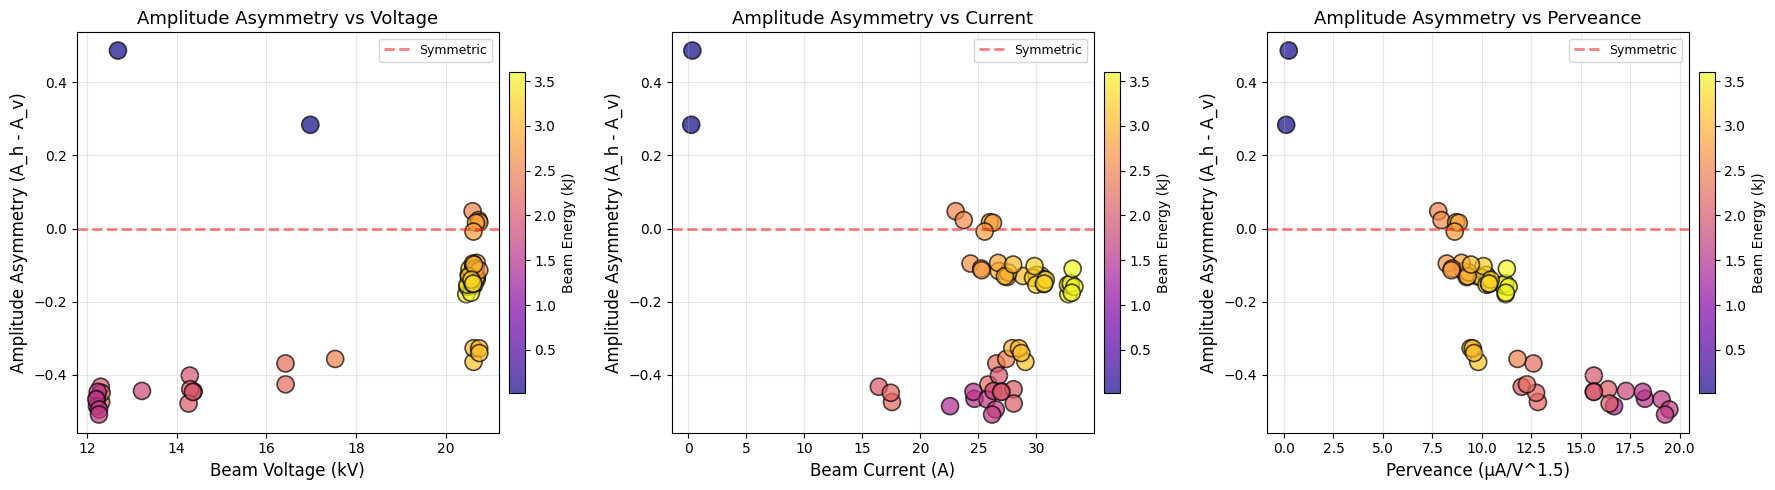


INTERPRETATION
  - Positive A_h-A_v: horizontal wires measure higher amplitude
  - Negative A_h-A_v: vertical wires measure higher amplitude
  - Zero A_h-A_v: symmetric beam (equal amplitudes)

2D Gaussian fitting complete!


In [96]:
# 2D GAUSSIAN BEAM PROFILE FITTING
import numpy as np
from scipy.optimize import curve_fit

def gaussian_1d(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2*sigma**2))

def fit_2d_gaussian_from_wire_data(h, v, dx=0.75, plot=False):
    """
    h: array-like, length 8, horizontal wire signals (integrated along x)
    v: array-like, length 8, vertical wire signals (integrated along y)
    dx: wire spacing (default = 0.75 inches or normalized units)

    Returns: x0, y0, sigma_x, sigma_y, amplitude A, A_h, A_v
    """

    # Wire coordinate positions (centered)
    # e.g., for 8 wires, positions = [-3.5*dx, -2.5*dx, ..., 3.5*dx]
    idx = np.arange(len(h))
    pos = (idx - (len(h)-1)/2) * dx

    # Fit horizontal wires (variation along y → gives y0, sigma_y)
    popt_h, _ = curve_fit(gaussian_1d, pos, h, p0=[np.max(h), 0.0, dx])
    A_h, y0, sigma_y = popt_h

    # Fit vertical wires (variation along x → gives x0, sigma_x)
    popt_v, _ = curve_fit(gaussian_1d, pos, v, p0=[np.max(v), 0.0, dx])
    A_v, x0, sigma_x = popt_v

    #pos and h and pos and v
    if plot:
        xx = np.linspace(pos.min(), pos.max(), 100)
        yh = A_h * np.exp(-(xx-y0)**2/(2*sigma_y**2))
        yv = A_v * np.exp(-(xx-x0)**2/(2*sigma_x**2))
        plt.plot(pos, h, 'o-', label='horizontal')
        plt.plot(pos, v, 'o-', label='vertical')
        plt.plot(xx, yh, '--', label='fit horizontal')
        plt.plot(xx, yv, '--', label='fit vertical')
        plt.legend()
        plt.show()
    
    # Recover 2D amplitude A
    # From horizontal fit: A_h ≈ A * sqrt(2π) * sigma_x
    # From vertical fit:   A_v ≈ A * sqrt(2π) * sigma_y
    A_from_h = A_h / (np.sqrt(2*np.pi) * sigma_x)
    A_from_v = A_v / (np.sqrt(2*np.pi) * sigma_y)

    # Average the two amplitude estimates
    A = 0.5*(A_from_h + A_from_v)

    return x0, y0, sigma_x, sigma_y, A, A_h, A_v

    


# ============================================================================
# FIT ALL SHOTS TO 2D GAUSSIAN
# ============================================================================

print("\n" + "="*100)
print("2D GAUSSIAN BEAM PROFILE FITTING")
print("="*100)

fit_results = []

if len(segment_df['Shot'].unique()) > 5:
    doplots = False
else:
    doplots = True
for shot_file in segment_df['Shot'].unique():
    shot_data = segment_df[segment_df['Shot'] == shot_file]
    beam_E = shot_data['Beam Energy (kJ)'].iloc[0]
    
    # Extract horizontal wires (w9-w16) - measure variation in x
    h = []
    for wire in ['w9', 'w10', 'w11', 'w12', 'w13', 'w14', 'w15', 'w16']:
        wire_data = shot_data[shot_data['Wire_Name'] == wire]
        if not wire_data.empty:
            h.append(wire_data['ΔT_seg/E (°C/kJ)'].values[0])
        else:
            h.append(np.nan)
    
    # Extract vertical wires (w1-w8) - measure variation in y  
    v = []
    for wire in ['w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8']:
        wire_data = shot_data[shot_data['Wire_Name'] == wire]
        if not wire_data.empty:
            v.append(wire_data['ΔT_seg/E (°C/kJ)'].values[0])
        else:
            v.append(np.nan)
    
    h = np.array(h)
    v = np.array(v)
    
    # Only fit if we have valid data        
    if not (np.any(np.isnan(h)) or np.any(np.isnan(v))):
        try:
            x0, y0, sigma_x, sigma_y, A, A_h, A_v = fit_2d_gaussian_from_wire_data(h, v, dx=0.75, plot=doplots)
            
            fit_results.append({
                'Shot': shot_file,
                'Beam_E (kJ)': beam_E,
                'x0 (in)': x0,
                'y0 (in)': y0,
                'sigma_x (in)': sigma_x,
                'sigma_y (in)': sigma_y,
                'Amplitude': A,
                'A_h': A_h,
                'A_v': A_v,
                'Delta_A_hv': A_h - A_v,
                'FWHM_x (in)': 2.355 * sigma_x,  # FWHM = 2.355 * sigma
                'FWHM_y (in)': 2.355 * sigma_y,
                'Aspect_Ratio': sigma_x / sigma_y
            })
            
            print(f"Shot {shot_file}:")
            print(f"  Gaussian center: (x0, y0) = ({x0:.3f}, {y0:.3f}) in")
            print(f"  Widths (sigma_x, sigma_y) = ({sigma_x:.3f}, {sigma_y:.3f}) in")
            print(f"  Amplitude A = {A:.3f}, A_h = {A_h:.3f}, A_v = {A_v:.3f}, Delta_A = {A_h - A_v:.3f}")
            
        except Exception as e:
            print(f"Warning: Could not fit shot {shot_file}: {e}")
    else:
        print(f"Warning: Skipping shot {shot_file} - missing wire data")

# Create DataFrame with results
fit_df = pd.DataFrame(fit_results)

if not fit_df.empty:
    print(f"\n\nSuccessfully fit {len(fit_df)} shots")
    print("\n" + "="*100)
    print("SUMMARY: BEAM PROFILE STATISTICS (across all shots)")
    print("="*100)
    print(f"Mean beam center:    x0 = {fit_df['x0 (in)'].mean():.3f} ± {fit_df['x0 (in)'].std():.3f} in")
    print(f"                     y0 = {fit_df['y0 (in)'].mean():.3f} ± {fit_df['y0 (in)'].std():.3f} in")
    print(f"Mean beam width:     σx = {fit_df['sigma_x (in)'].mean():.3f} ± {fit_df['sigma_x (in)'].std():.3f} in")
    print(f"                     σy = {fit_df['sigma_y (in)'].mean():.3f} ± {fit_df['sigma_y (in)'].std():.3f} in")
    print(f"Mean FWHM:           FWHMx = {fit_df['FWHM_x (in)'].mean():.3f} ± {fit_df['FWHM_x (in)'].std():.3f} in")
    print(f"                     FWHMy = {fit_df['FWHM_y (in)'].mean():.3f} ± {fit_df['FWHM_y (in)'].std():.3f} in")
    print(f"Mean aspect ratio:   σx/σy = {fit_df['Aspect_Ratio'].mean():.3f} ± {fit_df['Aspect_Ratio'].std():.3f}")
    print(f"Mean Delta_A (A_h - A_v):  {fit_df['Delta_A_hv'].mean():.3f} ± {fit_df['Delta_A_hv'].std():.3f}")
    
    # Save results to CSV
    output_csv = Path.home() / "shot_gaussian_fits.csv"
    fit_df.to_csv(output_csv, index=False)
    print(f"\nResults saved to: {output_csv}")
    
    # ============================================================================
    # PLOTTING: BEAM PROFILE VISUALIZATION
    # ============================================================================
    
    # Calculate mean beam profile from all shots
    mean_x0 = fit_df['x0 (in)'].mean()
    mean_y0 = fit_df['y0 (in)'].mean()
    mean_sigma_x = fit_df['sigma_x (in)'].mean()
    mean_sigma_y = fit_df['sigma_y (in)'].mean()
    mean_A = fit_df['Amplitude'].mean()
    
    # Create 2D grid for visualization
    x = np.linspace(-4, 4, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    
    # 2D Gaussian function
    Z = mean_A * np.exp(-((X - mean_x0)**2 / (2*mean_sigma_x**2) + (Y - mean_y0)**2 / (2*mean_sigma_y**2)))
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: 2D heatmap of mean beam profile
    ax = axes[0]
    im = ax.contourf(X, Y, Z, levels=20, cmap='hot')
    ax.set_xlabel('x (inches)', fontsize=12)
    ax.set_ylabel('y (inches)', fontsize=12)
    ax.set_title('Mean 2D Gaussian Beam Profile', fontsize=14)
    ax.axhline(y=mean_y0, color='cyan', linestyle='--', alpha=0.5, label=f'y0={mean_y0:.2f}"')
    ax.axvline(x=mean_x0, color='cyan', linestyle='--', alpha=0.5, label=f'x0={mean_x0:.2f}"')
    
    # Add wire positions
    wire_x_pos = np.arange(8) * 0.75 - 2.625  # Horizontal wire positions
    wire_y_pos = np.arange(8) * 0.75 - 2.625  # Vertical wire positions
    for wx in wire_x_pos:
        ax.axvline(x=wx, color='white', linestyle=':', alpha=0.3, linewidth=0.5)
    for wy in wire_y_pos:
        ax.axhline(y=wy, color='white', linestyle=':', alpha=0.3, linewidth=0.5)
    
    ax.legend(loc='upper right', fontsize=10)
    ax.set_aspect('equal')
    plt.colorbar(im, ax=ax, label='Amplitude')
    
    # Plot 2: Beam center positions (x0, y0) for all shots
    ax = axes[1]
    ax.scatter(fit_df['x0 (in)'], fit_df['y0 (in)'], s=100, alpha=0.6, edgecolor='black')
    ax.scatter(mean_x0, mean_y0, s=300, marker='*', color='red', edgecolor='black', 
               linewidth=2, label=f'Mean ({mean_x0:.2f}", {mean_y0:.2f}")', zorder=10)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('x0 (inches)', fontsize=12)
    ax.set_ylabel('y0 (inches)', fontsize=12)
    ax.set_title('Beam Center Positions (All Shots)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    ax.set_aspect('equal')
    
    # Plot 3: Beam widths (sigma_x, sigma_y) for all shots
    ax = axes[2]
    ax.scatter(fit_df['sigma_x (in)'], fit_df['sigma_y (in)'], s=100, alpha=0.6, edgecolor='black')
    ax.scatter(mean_sigma_x, mean_sigma_y, s=300, marker='*', color='red', edgecolor='black',
               linewidth=2, label=f'Mean ({mean_sigma_x:.2f}", {mean_sigma_y:.2f}")', zorder=10)
    
    # Add aspect ratio line
    max_sigma = max(fit_df['sigma_x (in)'].max(), fit_df['sigma_y (in)'].max()) * 1.1
    ax.plot([0, max_sigma], [0, max_sigma], 'k--', alpha=0.3, label='1:1 aspect ratio')
    
    ax.set_xlabel('σx (inches)', fontsize=12)
    ax.set_ylabel('σy (inches)', fontsize=12)
    ax.set_title('Beam Widths (All Shots)', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    # ============================================================================
    # AMPLITUDE ASYMMETRY (A_h - A_v) VS BEAM VOLTAGE
    # ============================================================================
    #a_h-a_v is the difference between horizontal and veritcal wires ampls for each shot
    #negative emp means vertical wires receive higher signal and at zero perf symmetry
    #we have a 2d gaussian beam profile and what the wires measure is like integreating the beam intensity along the y direction  so we
    # have two 1d gaussians in x with ampltidues Av=A*sqrt(2pi)sigmay
    #So DeltaA=Asqrt(2pi)(sigmaX-sigmaY) which means if σx>σy (beam wider in x) then A>0 positive assymetry
    #and if σx<σy (beam wider in y) and if equal sigmas then circular beam
 
#

    print("\n" + "="*100)
    print("AMPLITUDE ASYMMETRY (A_h - A_v) VS BEAM VOLTAGE ANALYSIS")
    print("="*100)
    
    # Add beam voltage, current, and perveance to fit_df if not already present
    if 'Beam_V (kV)' not in fit_df.columns:
        fit_df['Beam_V (kV)'] = fit_df['Shot'].map(beam_voltages)
    
    if 'Beam_I (A)' not in fit_df.columns:
        fit_df['Beam_I (A)'] = fit_df['Shot'].map(beam_currents)
    
    if 'Perveance (A/V^1.5)' not in fit_df.columns:
        fit_df['Perveance (A/V^1.5)'] = fit_df['Beam_I (A)'] / (fit_df['Beam_V (kV)'] * 1000)**1.5
    
    # Remove rows with missing data
    fit_df_clean = fit_df.dropna(subset=['Beam_V (kV)', 'Delta_A_hv', 'A_h', 'A_v'])
    
    print(f"\n{len(fit_df_clean)} shots have valid beam voltage and amplitude asymmetry data")
    
    # Print per-shot information
    print("\nPer-shot amplitude asymmetry:")
    for _, row in fit_df_clean.iterrows():
        shot_num = int(Path(row['Shot']).stem)
        beam_i = row['Beam_I (A)'] if 'Beam_I (A)' in row and not np.isnan(row['Beam_I (A)']) else np.nan
        perv = row['Perveance (A/V^1.5)'] * 1e6 if 'Perveance (A/V^1.5)' in row and not np.isnan(row['Perveance (A/V^1.5)']) else np.nan
        print(f"Shot {shot_num}: V={row['Beam_V (kV)']:.2f} kV | I={beam_i:.3f} A | P={perv:.1f} μA/V^1.5 | A_h={row['A_h']:.4f} | A_v={row['A_v']:.4f} | ΔA={row['Delta_A_hv']:.4f}")
    
    print(f"\nMean A_h - A_v: {fit_df_clean['Delta_A_hv'].mean():.4f}")
    print(f"Std A_h - A_v: {fit_df_clean['Delta_A_hv'].std():.4f}")
    print(f"Range: {fit_df_clean['Delta_A_hv'].min():.4f} to {fit_df_clean['Delta_A_hv'].max():.4f}")
    
    # ============================================================================
    # PLOTTING: AMPLITUDE ASYMMETRY VS VOLTAGE, CURRENT, AND PERVEANCE
    # ============================================================================
    
    if not fit_df_clean.empty:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot 1: Amplitude Asymmetry vs Voltage
        ax = axes[0]
        scatter1 = ax.scatter(fit_df_clean['Beam_V (kV)'], fit_df_clean['Delta_A_hv'], 
                            c=fit_df_clean['Beam_E (kJ)'], s=150, alpha=0.7, 
                            edgecolor='black', cmap='plasma', linewidth=1.2)
        
        ax.set_xlabel('Beam Voltage (kV)', fontsize=12)
        ax.set_ylabel('Amplitude Asymmetry (A_h - A_v)', fontsize=12)
        ax.set_title('Amplitude Asymmetry vs Voltage', fontsize=13)
        ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Symmetric')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=9)
        
        cb1 = plt.colorbar(scatter1, ax=ax, pad=0.02, aspect=20, shrink=0.8, label='Beam Energy (kJ)')
        
        # Plot 2: Amplitude Asymmetry vs Current
        ax = axes[1]
        # Filter for shots with current data
        fit_df_with_current = fit_df_clean.dropna(subset=['Beam_I (A)'])
        
        if not fit_df_with_current.empty:
            scatter2 = ax.scatter(fit_df_with_current['Beam_I (A)'], fit_df_with_current['Delta_A_hv'], 
                                c=fit_df_with_current['Beam_E (kJ)'], s=150, alpha=0.7, 
                                edgecolor='black', cmap='plasma', linewidth=1.2)
            
            ax.set_xlabel('Beam Current (A)', fontsize=12)
            ax.set_ylabel('Amplitude Asymmetry (A_h - A_v)', fontsize=12)
            ax.set_title('Amplitude Asymmetry vs Current', fontsize=13)
            ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Symmetric')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='best', fontsize=9)
            
            cb2 = plt.colorbar(scatter2, ax=ax, pad=0.02, aspect=20, shrink=0.8, label='Beam Energy (kJ)')
        else:
            ax.text(0.5, 0.5, 'No current data available', ha='center', va='center', transform=ax.transAxes)
            ax.set_xlabel('Beam Current (A)', fontsize=12)
            ax.set_ylabel('Amplitude Asymmetry (A_h - A_v)', fontsize=12)
            ax.set_title('Amplitude Asymmetry vs Current', fontsize=13)
        
        # Plot 3: Amplitude Asymmetry vs Perveance
        ax = axes[2]
        # Filter for shots with perveance data
        fit_df_with_perv = fit_df_clean.dropna(subset=['Perveance (A/V^1.5)'])
        
        if not fit_df_with_perv.empty:
            scatter3 = ax.scatter(fit_df_with_perv['Perveance (A/V^1.5)'] * 1e6, fit_df_with_perv['Delta_A_hv'], 
                                c=fit_df_with_perv['Beam_E (kJ)'], s=150, alpha=0.7, 
                                edgecolor='black', cmap='plasma', linewidth=1.2)
            
            ax.set_xlabel('Perveance (μA/V^1.5)', fontsize=12)
            ax.set_ylabel('Amplitude Asymmetry (A_h - A_v)', fontsize=12)
            ax.set_title('Amplitude Asymmetry vs Perveance', fontsize=13)
            ax.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Symmetric')
            ax.grid(True, alpha=0.3)
            ax.legend(loc='best', fontsize=9)
            
            cb3 = plt.colorbar(scatter3, ax=ax, pad=0.02, aspect=20, shrink=0.8, label='Beam Energy (kJ)')
        else:
            ax.text(0.5, 0.5, 'No perveance data available', ha='center', va='center', transform=ax.transAxes)
            ax.set_xlabel('Perveance (μA/V^1.5)', fontsize=12)
            ax.set_ylabel('Amplitude Asymmetry (A_h - A_v)', fontsize=12)
            ax.set_title('Amplitude Asymmetry vs Perveance', fontsize=13)
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*100)
        print("INTERPRETATION")
        print("="*100)
        print(f"  - Positive A_h-A_v: horizontal wires measure higher amplitude")
        print(f"  - Negative A_h-A_v: vertical wires measure higher amplitude")
        print(f"  - Zero A_h-A_v: symmetric beam (equal amplitudes)")
        
    else:
        print("\nNo data available for Amplitude Asymmetry vs Voltage plot!")
    
else:
    print("\nNo successful fits!")

print("\n" + "="*100)
print("2D Gaussian fitting complete!")
print("="*100)



FETCHING BEAM CURRENT DATA FOR PERVEANCE ANALYSIS
Shot 112560: Avg beam current = 16.416 A
Shot 112561: Avg beam current = 17.552 A
Shot 112562: Avg beam current = 17.447 A
Shot 112696: Avg beam current = 25.856 A
Shot 112697: Avg beam current = 0.344 A
Shot 112698: Avg beam current = 24.660 A
Shot 112699: Avg beam current = 24.572 A
Shot 112708: Avg beam current = 29.047 A
Shot 112709: Avg beam current = 0.244 A
Shot 112712: Avg beam current = 26.544 A
Shot 112713: Avg beam current = 27.403 A
Shot 112714: Avg beam current = 22.556 A
Shot 112715: Avg beam current = 25.747 A
Shot 112716: Avg beam current = 27.920 A
Shot 112717: Avg beam current = 28.497 A
Shot 112718: Avg beam current = 26.765 A
Shot 112719: Avg beam current = 26.300 A
Shot 112720: Avg beam current = 27.017 A
Shot 112721: Avg beam current = 28.034 A
Shot 112722: Avg beam current = 28.044 A
Shot 112724: Avg beam current = 26.962 A
Shot 112725: Avg beam current = 26.489 A
Shot 112726: Avg beam current = 26.182 A
Shot 112

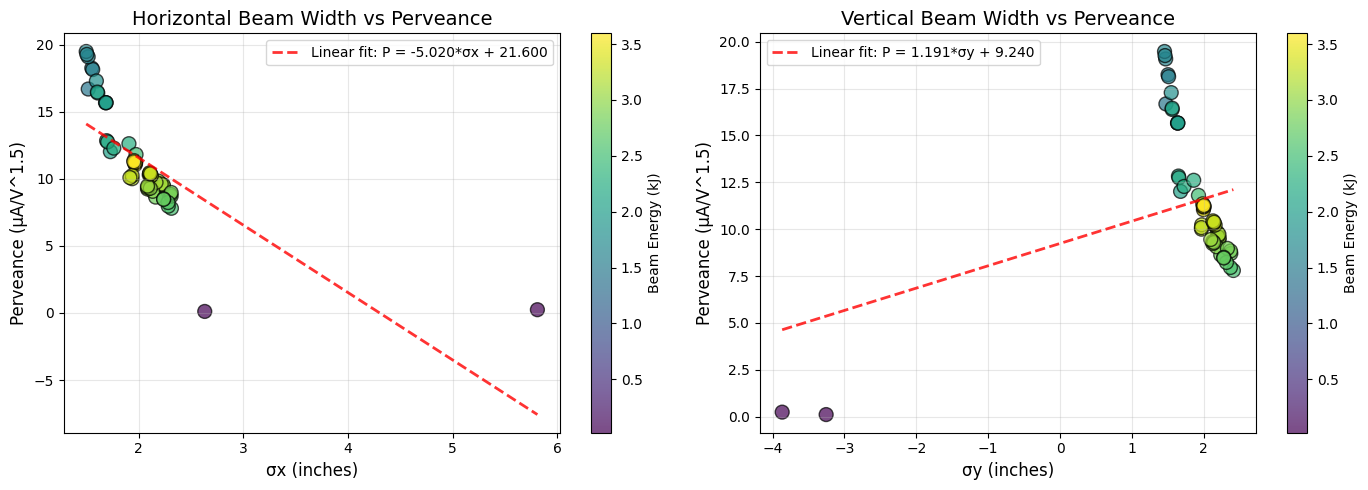


CORRELATION: BEAM WIDTH vs PERVEANCE
Correlation coefficient (Perveance vs σx):     -0.744
Correlation coefficient (Perveance vs σy):     0.329

Perveance range: 0.110 to 19.482 μA/V^1.5
Mean perveance: 11.344 ± 3.932 μA/V^1.5

Results with perveance data saved to: /u/hgajani/shot_gaussian_fits_with_perveance.csv

Beam width vs perveance analysis complete!


In [97]:
# BEAM WIDTH VS PERVEANCE ANALYSIS
# Perveance = I / V^1.5

print("\n" + "="*100)
print("FETCHING BEAM CURRENT DATA FOR PERVEANCE ANALYSIS")
print("="*100)

# Fetch beam current for each shot in fit_df
beam_currents = {}

for shot_file in fit_df['Shot'].unique():
    shot_num = int(Path(shot_file).stem)
    
    try:
        if shot_num > 200000:
            treename = 'ltx_nbi'
            prefix = ''
        else:
            treename = 'ltx_b'
            prefix = '.oper_diags.ltx_nbi'
        
        tree = get_tree_conn(shot_num, treename=treename)
        (ti, ib) = get_data(tree, f'{prefix}.source_diags.i_hvps')
        (tv, vb) = get_data(tree, f'{prefix}.source_diags.v_hvps')
        
        # Interpolate current onto voltage time base
        ib_interp = np.interp(tv, ti, ib)
        
        # Get current during beam-on period (voltage > 5 kV)
        mask = vb > 5000.0
        if np.any(mask):
            avg_current = np.mean(ib_interp[mask])
            beam_currents[shot_file] = avg_current
            print(f"Shot {shot_num}: Avg beam current = {avg_current:.3f} A")
        else:
            beam_currents[shot_file] = np.nan
            print(f"Shot {shot_num}: No beam-on data")
            
    except Exception as e:
        print(f"Warning: Could not fetch current for shot {shot_num}: {e}")
        beam_currents[shot_file] = np.nan

# Add beam current to fit_df if not already present
if 'Beam_I (A)' not in fit_df.columns:
    fit_df['Beam_I (A)'] = fit_df['Shot'].map(beam_currents)

# Calculate perveance = I / V^1.5 (with voltage in V, not kV)
fit_df['Perveance (A/V^1.5)'] = fit_df['Beam_I (A)'] / (fit_df['Beam_V (kV)'] * 1000)**1.5

# Remove rows with missing perveance data
fit_df_perv = fit_df.dropna(subset=['Perveance (A/V^1.5)'])

print(f"\n{len(fit_df_perv)} shots have valid perveance data for plotting")

# ============================================================================
# PLOTTING: BEAM WIDTH VS PERVEANCE
# ============================================================================

if not fit_df_perv.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: sigma_x vs perveance
    ax = axes[0]
    scatter = ax.scatter(fit_df_perv['sigma_x (in)'], fit_df_perv['Perveance (A/V^1.5)'] * 1e6, 
                        c=fit_df_perv['Beam_E (kJ)'], s=100, alpha=0.7, 
                        edgecolor='black', cmap='viridis')
    ax.set_xlabel('σx (inches)', fontsize=12)
    ax.set_ylabel('Perveance (μA/V^1.5)', fontsize=12)
    ax.set_title('Horizontal Beam Width vs Perveance', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Beam Energy (kJ)')
    
    # Add trend line
    z = np.polyfit(fit_df_perv['sigma_x (in)'], fit_df_perv['Perveance (A/V^1.5)'] * 1e6, 1)
    p = np.poly1d(z)
    x_line = np.linspace(fit_df_perv['sigma_x (in)'].min(), fit_df_perv['sigma_x (in)'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8, 
            label=f'Linear fit: P = {z[0]:.3f}*σx + {z[1]:.3f}')
    ax.legend(loc='best', fontsize=10)
    
    # Plot 2: sigma_y vs perveance
    ax = axes[1]
    scatter = ax.scatter(fit_df_perv['sigma_y (in)'], fit_df_perv['Perveance (A/V^1.5)'] * 1e6, 
                        c=fit_df_perv['Beam_E (kJ)'], s=100, alpha=0.7, 
                        edgecolor='black', cmap='viridis')
    ax.set_xlabel('σy (inches)', fontsize=12)
    ax.set_ylabel('Perveance (μA/V^1.5)', fontsize=12)
    ax.set_title('Vertical Beam Width vs Perveance', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Beam Energy (kJ)')
    
    # Add trend line
    z = np.polyfit(fit_df_perv['sigma_y (in)'], fit_df_perv['Perveance (A/V^1.5)'] * 1e6, 1)
    p = np.poly1d(z)
    x_line = np.linspace(fit_df_perv['sigma_y (in)'].min(), fit_df_perv['sigma_y (in)'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8, 
            label=f'Linear fit: P = {z[0]:.3f}*σy + {z[1]:.3f}')
    ax.legend(loc='best', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation statistics
    print("\n" + "="*100)
    print("CORRELATION: BEAM WIDTH vs PERVEANCE")
    print("="*100)
    
    corr_sigma_x = fit_df_perv[['Perveance (A/V^1.5)', 'sigma_x (in)']].corr().iloc[0, 1]
    corr_sigma_y = fit_df_perv[['Perveance (A/V^1.5)', 'sigma_y (in)']].corr().iloc[0, 1]
    
    print(f"Correlation coefficient (Perveance vs σx):     {corr_sigma_x:.3f}")
    print(f"Correlation coefficient (Perveance vs σy):     {corr_sigma_y:.3f}")
    
    # Print summary statistics
    print(f"\nPerveance range: {fit_df_perv['Perveance (A/V^1.5)'].min()*1e6:.3f} to {fit_df_perv['Perveance (A/V^1.5)'].max()*1e6:.3f} μA/V^1.5")
    print(f"Mean perveance: {fit_df_perv['Perveance (A/V^1.5)'].mean()*1e6:.3f} ± {fit_df_perv['Perveance (A/V^1.5)'].std()*1e6:.3f} μA/V^1.5")
    
    # Save updated results with perveance data
    output_csv_with_perveance = Path.home() / "shot_gaussian_fits_with_perveance.csv"
    fit_df_perv.to_csv(output_csv_with_perveance, index=False)
    print(f"\nResults with perveance data saved to: {output_csv_with_perveance}")
    
else:
    print("\nNo valid data for beam width vs perveance plots!")

print("\n" + "="*100)
print("Beam width vs perveance analysis complete!")
print("="*100)


Aperture parameters: x_s = 4.0 in, x_o = 4.797 in
Shot 112560: Transmission = 96.12% | Power through = 1.97 kJ
Shot 112561: Transmission = 96.57% | Power through = 2.11 kJ
Shot 112562: Transmission = 96.48% | Power through = 2.10 kJ
Shot 112696: Transmission = 95.53% | Power through = 2.14 kJ
Shot 112697: Transmission = -30.63% | Power through = -0.01 kJ
Shot 112698: Transmission = 98.11% | Power through = 1.53 kJ
Shot 112699: Transmission = 98.03% | Power through = 1.52 kJ
Shot 112708: Transmission = 86.82% | Power through = 2.74 kJ
Shot 112709: Transmission = -63.50% | Power through = -0.01 kJ
Shot 112712: Transmission = 93.23% | Power through = 2.11 kJ
Shot 112713: Transmission = 91.97% | Power through = 2.29 kJ
Shot 112714: Transmission = 98.37% | Power through = 1.40 kJ
Shot 112715: Transmission = 98.38% | Power through = 1.59 kJ
Shot 112716: Transmission = 86.02% | Power through = 2.60 kJ
Shot 112717: Transmission = 86.02% | Power through = 2.64 kJ
Shot 112718: Transmission = 96

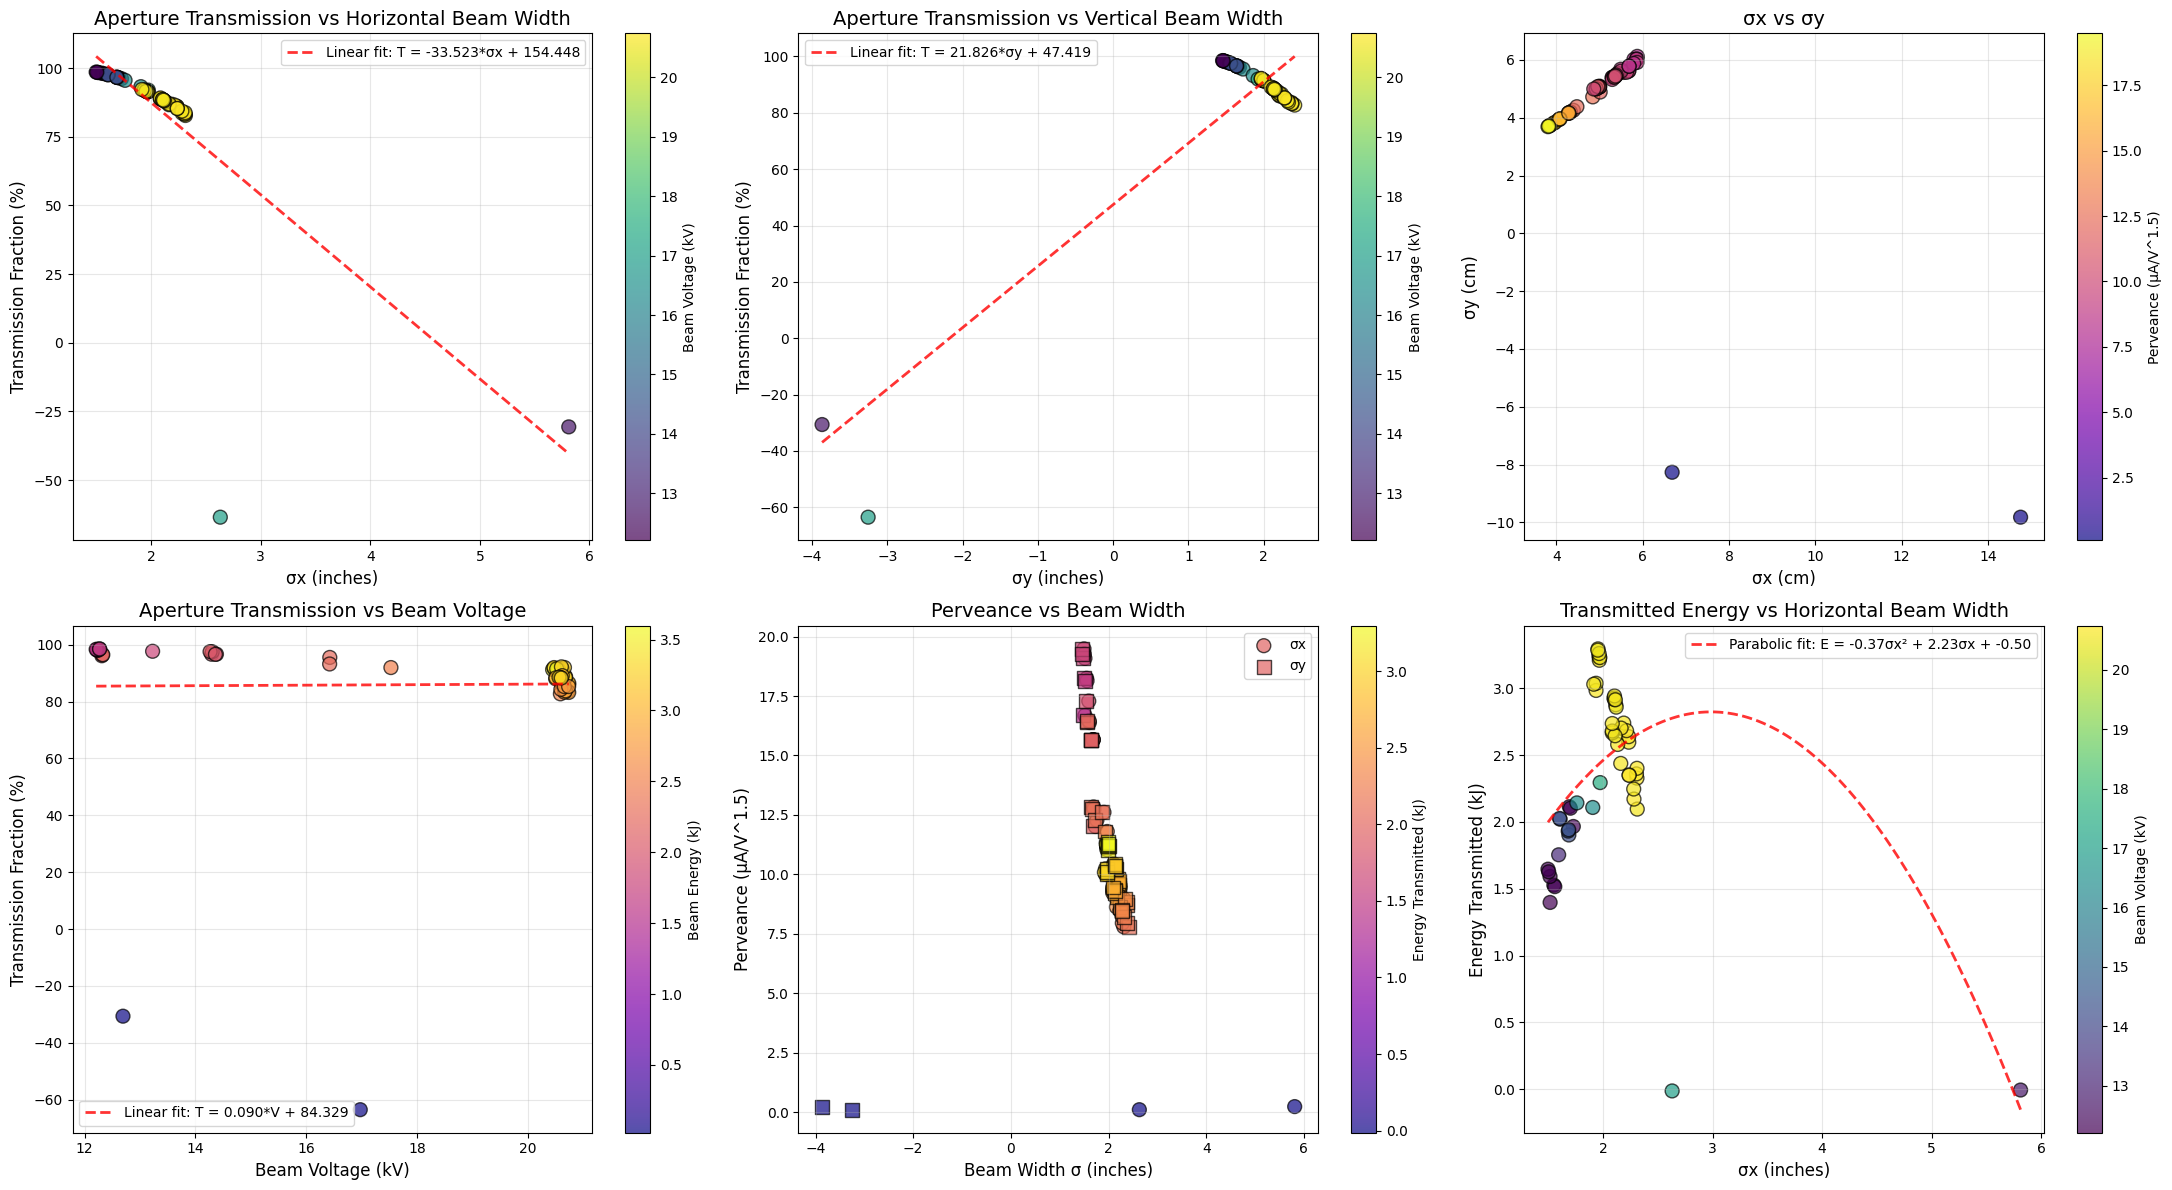


CORRELATIONS: APERTURE TRANSMISSION
Correlation coefficient (Transmission vs σx):        -0.731
Correlation coefficient (Transmission vs σy):        0.886
Correlation coefficient (Transmission vs Voltage):   0.012
Correlation coefficient (Transmission vs Perveance): 0.681

Results with aperture transmission saved to: /u/hgajani/shot_gaussian_fits_with_aperture.csv

BEAM CENTER POSITION ANALYSIS

Shot data sorted by y₀ position (bottom to top):
 Shot_Number   x0 (in)   y0 (in)  Perveance (μA/V^1.5)  Beam_V (kV)  Beam_E (kJ)
      112697 -2.730803 -1.548838              0.240222    12.693295     0.022706
      112709  1.349022 -0.631435              0.110388    16.977268     0.021617
      112715 -0.202951 -0.272159             19.084677    12.209306     1.617920
      112714 -0.194969 -0.270510             16.684599    12.226229     1.420672
      112726 -0.190714 -0.269508             19.263216    12.270191     1.652157
      112698 -0.172989 -0.261703             18.243949    12.2249

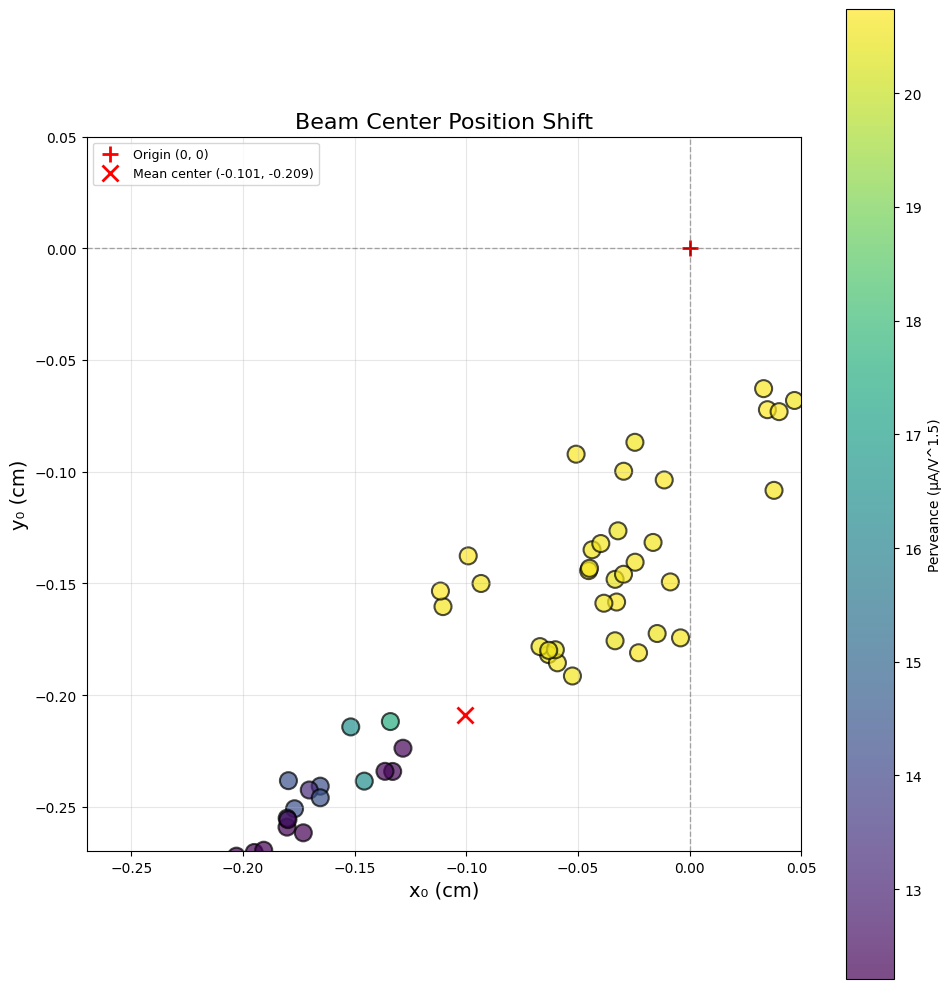


Beam center statistics:
  x₀: -0.1007 ± 0.4154 inches
  y₀: -0.2088 ± 0.2027 inches
  x₀ range: [-2.7308, 1.3490] inches
  y₀ range: [-1.5488, -0.0628] inches

Distance from origin: 0.2757 ± 0.4370 inches
Max displacement: 3.1395 inches

Aperture transmission analysis complete!


In [98]:
# BEAM POWER THROUGH WIRE-CAL APERTURE CALCULATION
# Calculate fraction of Gaussian beam power passing through octagonal aperture

from scipy.integrate import dblquad


# ----------------------------------------
# Point-in-polygon: ray-casting algorithm
# ----------------------------------------
def point_in_poly(x, y, poly):
    """
    Ray-casting point-in-polygon test.
    poly: list of (x,y) vertices in order (clockwise or ccw).
    Returns True if (x,y) inside poly (including boundary).
    """
    inside = False
    n = len(poly)
    for i in range(n):
        x1, y1 = poly[i]
        x2, y2 = poly[(i + 1) % n]
        # Check if edge crosses horizontal ray to right of point
        # Count intersections with half-open segment rule
        if ((y1 > y) != (y2 > y)):
            # Compute x coordinate of intersection of edge with horizontal line y
            x_int = x1 + (y - y1) * (x2 - x1) / (y2 - y1)
            if x_int >= x:
                inside = not inside
        # If point is exactly on an edge (collinear and between endpoints), consider inside
        # We'll do a small tolerance check for boundary cases:
        eps = 1e-12
        # Check if point lies exactly on segment (x1,y1)-(x2,y2)
        cross = (x - x1) * (y2 - y1) - (y - y1) * (x2 - x1)
        if abs(cross) < eps:
            dot = (x - x1) * (x2 - x1) + (y - y1) * (y2 - y1)
            if dot >= -eps and dot <= ((x2-x1)**2 + (y2-y1)**2) + eps:
                return True
    return inside

# ----------------------------------------
# Build polygon vertices automatically
# ----------------------------------------
def build_octagon(x_s, x_o):
    """
    Build the octagonal polygon vertices for the shape defined by:
      vertical/horizontal lines at x = +/- x_s, y = +/- x_s
      diagonal lines at (x + y)/sqrt(2) = +/- x_o  and (x - y)/sqrt(2) = +/- x_o
    Returns polygon vertices in CCW order.
    """
    d = np.sqrt(2.0) * x_o

    # Define the 8 line equations in a simple param type:
    # we'll compute intersections of all pairs and keep those inside the square bounds.
    # Line types: ('v', a) vertical x=a; ('h', b) horizontal y=b;
    # ('p', d) diagonal x+y=d; ('m', d) diagonal x-y=d
    lines = [
        ('v',  x_s), ('v', -x_s),
        ('h',  x_s), ('h', -x_s),
        ('p',  d),   ('p', -d),
        ('m',  d),   ('m', -d)
    ]

    # Compute intersections of each pair
    pts = []
    for i in range(len(lines)):
        t1, a1 = lines[i]
        for j in range(i+1, len(lines)):
            t2, a2 = lines[j]

            # Solve intersection
            x = None; y = None
            if t1 == 'v' and t2 == 'h':
                x = a1; y = a2
            elif t1 == 'h' and t2 == 'v':
                x = a2; y = a1
            elif t1 == 'v' and t2 == 'p':
                x = a1; y = a2 - a1
            elif t1 == 'p' and t2 == 'v':
                x = a2; y = a1 - a2
            elif t1 == 'v' and t2 == 'm':
                x = a1; y = a1 - a2
            elif t1 == 'm' and t2 == 'v':
                x = a2; y = a2 - a1
            elif t1 == 'h' and t2 == 'p':
                y = a1; x = a2 - a1
            elif t1 == 'p' and t2 == 'h':
                y = a2; x = a1 - a2
            elif t1 == 'h' and t2 == 'm':
                y = a1; x = a1 + a2
            elif t1 == 'm' and t2 == 'h':
                y = a2; x = a2 + a1
            elif t1 == 'p' and t2 == 'm':
                # x + y = a1
                # x - y = a2
                x = 0.5 * (a1 + a2)
                y = 0.5 * (a1 - a2)
            elif t1 == 'm' and t2 == 'p':
                x = 0.5 * (a2 + a1)
                y = 0.5 * (a2 - a1)
            else:
                # same type intersection or unhandled pair - skip
                continue

            if x is None or y is None:
                continue

            # Keep only points inside the main square bounds (with a tolerance)
            if abs(x) <= x_s + 1e-9 and abs(y) <= x_s + 1e-9:
                pts.append((round(x,12), round(y,12)))

    # Unique and sort points by angle to form polygon (center = (0,0))
    unique_pts = []
    for p in pts:
        if p not in unique_pts:
            unique_pts.append(p)
    # sort by angle around origin
    unique_pts.sort(key=lambda p: np.arctan2(p[1], p[0]))
    return unique_pts

# ----------------------------------------
# 2D Gaussian integrand (unnormalized)
# ----------------------------------------
def gaussian2d(x, y, x0, y0, sigma_x, sigma_y):
    ex = np.exp(-((x - x0)**2)/(2*sigma_x**2))
    ey = np.exp(-((y - y0)**2)/(2*sigma_y**2))
    return ex * ey

# ----------------------------------------
# Fraction calculation via dblquad
# ----------------------------------------
def gaussian_fraction_octagon(x0, y0, sigma_x, sigma_y, x_s, x_o, epsabs=1e-6, epsrel=1e-6):
    """
    Compute fraction of 2D Gaussian power inside the octagon defined by x_s and x_o.
    Uses adaptive 2D integration over the bounding square [-x_s,x_s] x [-x_s,x_s],
    multiplying the gaussian by 1_{inside polygon} and dividing by total integral.
    """
    poly = build_octagon(x_s, x_o)
    if len(poly) < 4:
        raise ValueError("Failed to build polygon vertices. Check x_s and x_o inputs.")

    # Total integral normalization for 2D Gaussian (A cancels)
    total = 2.0 * np.pi * sigma_x * sigma_y

    # integrand for dblquad: integrate over x outer, y inner
    def inner_y(y, x):
        # return gaussian value if inside polygon; else 0
        if point_in_poly(x, y, poly):
            return gaussian2d(x, y, x0, y0, sigma_x, sigma_y)
        else:
            return 0.0

    # Integrate over bounding square (x from -x_s..x_s, y from -x_s..x_s)
    # dblquad expects inner limits as functions of x; we give constant limits and the point-in-polygon guards inside integrand
    integral, err = dblquad(inner_y, -x_s, x_s, lambda x: -x_s, lambda x: x_s, epsabs=epsabs, epsrel=epsrel)

    # Note: gaussian2d above is product of unnormalized exponentials; multiply by normalization factor A_norm = 1/(2*pi*sx*sy)
    # So integral of gaussian2d over plane is (2*pi*sx*sy). We divide by that to get fraction.
    fraction = integral / total
    return fraction, poly, integral, err

# ============================================================================
# CALCULATE APERTURE TRANSMISSION FOR ALL SHOTS
# ============================================================================

# Wire-cal aperture dimensions (inches)
# Adjust these to match your actual aperture geometry
X_S = 4.0  # Half-width of square aperture (inches)
X_O = 9.594/2  # Octagon parameter (inches)

print(f"\nAperture parameters: x_s = {X_S} in, x_o = {X_O} in")

# Calculate aperture transmission for each shot
aperture_results = []

for idx, row in fit_df_perv.iterrows():
    shot_file = row['Shot']
    x0 = row['x0 (in)']
    y0 = row['y0 (in)']
    sigma_x = row['sigma_x (in)']
    sigma_y = row['sigma_y (in)']
    beam_E = row['Beam_E (kJ)']
    
    try:
        frac, polygon, integral, err = gaussian_fraction_octagon(
            x0, y0, sigma_x, sigma_y, X_S, X_O, epsabs=1e-6, epsrel=1e-6
        )
        
        # Calculate power through aperture
        power_through = frac * beam_E  # kJ
        
        aperture_results.append({
            'Shot': shot_file,
            'Beam_E (kJ)': beam_E,
            'Transmission_Fraction': frac,
            'Power_Through_Aperture (kJ)': power_through,
            'Integration_Error': err
        })
        
        shot_num = int(Path(shot_file).stem)
        print(f"Shot {shot_num}: Transmission = {frac*100:.2f}% | Power through = {power_through:.2f} kJ")
        
    except Exception as e:
        print(f"Warning: Could not calculate aperture transmission for shot {shot_file}: {e}")

# Create DataFrame with aperture results
aperture_df = pd.DataFrame(aperture_results)

if not aperture_df.empty:
    # Merge aperture results with fit_df_perv
    fit_df_aperture = fit_df_perv.merge(aperture_df, on=['Shot', 'Beam_E (kJ)'], how='left')
    
    print("\n" + "="*100)
    print("APERTURE TRANSMISSION STATISTICS")
    print("="*100)
    print(f"Mean transmission fraction: {aperture_df['Transmission_Fraction'].mean()*100:.2f} ± {aperture_df['Transmission_Fraction'].std()*100:.2f}%")
    print(f"Transmission range: {aperture_df['Transmission_Fraction'].min()*100:.2f}% to {aperture_df['Transmission_Fraction'].max()*100:.2f}%")
    print(f"Mean power through aperture: {aperture_df['Power_Through_Aperture (kJ)'].mean():.2f} ± {aperture_df['Power_Through_Aperture (kJ)'].std():.2f} kJ")
    
    # ============================================================================
    # PLOTTING: APERTURE TRANSMISSION ANALYSIS
    # ============================================================================
    
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))
    
    # Plot 1: Transmission fraction vs horizontal beam width (sigma_x)
    ax = axes[0, 0]
    scatter = ax.scatter(fit_df_aperture['sigma_x (in)'], fit_df_aperture['Transmission_Fraction'] * 100,
                        c=fit_df_aperture['Beam_V (kV)'], s=100, alpha=0.7,
                        edgecolor='black', cmap='viridis')
    ax.set_xlabel('σx (inches)', fontsize=12)
    ax.set_ylabel('Transmission Fraction (%)', fontsize=12)
    ax.set_title('Aperture Transmission vs Horizontal Beam Width', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Beam Voltage (kV)')
    
    # Add trend line
    z = np.polyfit(fit_df_aperture['sigma_x (in)'], fit_df_aperture['Transmission_Fraction'] * 100, 1)
    p = np.poly1d(z)
    x_line = np.linspace(fit_df_aperture['sigma_x (in)'].min(), fit_df_aperture['sigma_x (in)'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8,
            label=f'Linear fit: T = {z[0]:.3f}*σx + {z[1]:.3f}')
    ax.legend(loc='best', fontsize=10)
    
    # Plot 2: Transmission fraction vs vertical beam width (sigma_y)
    ax = axes[0, 1]
    scatter = ax.scatter(fit_df_aperture['sigma_y (in)'], fit_df_aperture['Transmission_Fraction'] * 100,
                        c=fit_df_aperture['Beam_V (kV)'], s=100, alpha=0.7,
                        edgecolor='black', cmap='viridis')
    ax.set_xlabel('σy (inches)', fontsize=12)
    ax.set_ylabel('Transmission Fraction (%)', fontsize=12)
    ax.set_title('Aperture Transmission vs Vertical Beam Width', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Beam Voltage (kV)')
    
    # Add trend line
    z = np.polyfit(fit_df_aperture['sigma_y (in)'], fit_df_aperture['Transmission_Fraction'] * 100, 1)
    p = np.poly1d(z)
    x_line = np.linspace(fit_df_aperture['sigma_y (in)'].min(), fit_df_aperture['sigma_y (in)'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8,
            label=f'Linear fit: T = {z[0]:.3f}*σy + {z[1]:.3f}')
    ax.legend(loc='best', fontsize=10)
    
    # Plot 3: Transmission fraction vs beam voltage
    ax = axes[1, 0]
    scatter = ax.scatter(fit_df_aperture['Beam_V (kV)'], fit_df_aperture['Transmission_Fraction'] * 100,
                        c=fit_df_aperture['Beam_E (kJ)'], s=100, alpha=0.7,
                        edgecolor='black', cmap='plasma')
    ax.set_xlabel('Beam Voltage (kV)', fontsize=12)
    ax.set_ylabel('Transmission Fraction (%)', fontsize=12)
    ax.set_title('Aperture Transmission vs Beam Voltage', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Beam Energy (kJ)')
    
    # Add trend line
    z = np.polyfit(fit_df_aperture['Beam_V (kV)'], fit_df_aperture['Transmission_Fraction'] * 100, 1)
    p = np.poly1d(z)
    x_line = np.linspace(fit_df_aperture['Beam_V (kV)'].min(), fit_df_aperture['Beam_V (kV)'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8,
            label=f'Linear fit: T = {z[0]:.3f}*V + {z[1]:.3f}')
    ax.legend(loc='best', fontsize=10)
    
    # Plot 4: Perveance vs beam width colored by energy transmitted
    ax = axes[1, 1]
    # Calculate energy transmitted for color scale
    fit_df_aperture['Energy_Transmitted (kJ)'] = fit_df_aperture['Beam_E (kJ)'] * fit_df_aperture['Transmission_Fraction']
    
    # Plot perveance vs sigma_x and sigma_y on same plot
    scatter1 = ax.scatter(fit_df_aperture['sigma_x (in)'], fit_df_aperture['Perveance (A/V^1.5)'] * 1e6,
                         c=fit_df_aperture['Energy_Transmitted (kJ)'], s=100, alpha=0.7,
                         edgecolor='black', cmap='plasma', marker='o', label='σx')
    scatter2 = ax.scatter(fit_df_aperture['sigma_y (in)'], fit_df_aperture['Perveance (A/V^1.5)'] * 1e6,
                         c=fit_df_aperture['Energy_Transmitted (kJ)'], s=100, alpha=0.7,
                         edgecolor='black', cmap='plasma', marker='s', label='σy')
    
    ax.set_xlabel('Beam Width σ (inches)', fontsize=12)
    ax.set_ylabel('Perveance (μA/V^1.5)', fontsize=12)
    ax.set_title('Perveance vs Beam Width', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=ax, label='Energy Transmitted (kJ)')
    ax.legend(loc='best', fontsize=10)
    
    # Plot 5: Transmitted energy vs horizontal beam width (sigma_x)
    ax = axes[1, 2]
    scatter = ax.scatter(fit_df_aperture['sigma_x (in)'], fit_df_aperture['Energy_Transmitted (kJ)'],
                        c=fit_df_aperture['Beam_V (kV)'], s=100, alpha=0.7,
                        edgecolor='black', cmap='viridis')
    ax.set_xlabel('σx (inches)', fontsize=12)
    ax.set_ylabel('Energy Transmitted (kJ)', fontsize=12)
    ax.set_title('Transmitted Energy vs Horizontal Beam Width', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Beam Voltage (kV)')
    
    # Add parabolic fit (2nd order polynomial)
    z = np.polyfit(fit_df_aperture['sigma_x (in)'], fit_df_aperture['Energy_Transmitted (kJ)'], 2)
    p = np.poly1d(z)
    x_line = np.linspace(fit_df_aperture['sigma_x (in)'].min(), fit_df_aperture['sigma_x (in)'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8,
            label=f'Parabolic fit: E = {z[0]:.2f}σx² + {z[1]:.2f}σx + {z[2]:.2f}')
    ax.legend(loc='best', fontsize=10)
    
    # Plot 6: sigma_y vs sigma_x colored by perveance (in centimeters)
    ax = axes[0, 2]
    scatter = ax.scatter(
        fit_df_aperture['sigma_x (in)'] * 2.54,
        fit_df_aperture['sigma_y (in)'] * 2.54,
        c=fit_df_aperture['Perveance (A/V^1.5)'] * 1e6,
        s=100, alpha=0.7,
        edgecolor='black', cmap='plasma'
    )
    ax.set_xlabel('σx (cm)', fontsize=12)
    ax.set_ylabel('σy (cm)', fontsize=12)
    ax.set_title('σx vs σy', fontsize=14)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Perveance (μA/V^1.5)')
    # (Reference line removed)
    
   
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation statistics
    print("\n" + "="*100)
    print("CORRELATIONS: APERTURE TRANSMISSION")
    print("="*100)
    
    corr_sigma_x = fit_df_aperture[['Transmission_Fraction', 'sigma_x (in)']].corr().iloc[0, 1]
    corr_sigma_y = fit_df_aperture[['Transmission_Fraction', 'sigma_y (in)']].corr().iloc[0, 1]
    corr_voltage = fit_df_aperture[['Transmission_Fraction', 'Beam_V (kV)']].corr().iloc[0, 1]
    corr_perv = fit_df_aperture[['Transmission_Fraction', 'Perveance (A/V^1.5)']].corr().iloc[0, 1]
    
    print(f"Correlation coefficient (Transmission vs σx):        {corr_sigma_x:.3f}")
    print(f"Correlation coefficient (Transmission vs σy):        {corr_sigma_y:.3f}")
    print(f"Correlation coefficient (Transmission vs Voltage):   {corr_voltage:.3f}")
    print(f"Correlation coefficient (Transmission vs Perveance): {corr_perv:.3f}")
    
    # Save results with aperture data
    output_csv_with_aperture = Path.home() / "shot_gaussian_fits_with_aperture.csv"
    fit_df_aperture.to_csv(output_csv_with_aperture, index=False)
    print(f"\nResults with aperture transmission saved to: {output_csv_with_aperture}")
    
    # ============================================================================
    # FIGURE 7: BEAM CENTER POSITION ANALYSIS
    # ============================================================================
    
    print("\n" + "="*100)
    print("BEAM CENTER POSITION ANALYSIS")
    print("="*100)
    
    # Print table of shot numbers with their perveance and beam center positions
    print("\nShot data sorted by y₀ position (bottom to top):")
    shot_table = fit_df_aperture[['Shot', 'x0 (in)', 'y0 (in)', 'Perveance (A/V^1.5)', 'Beam_V (kV)', 'Beam_E (kJ)']].copy()
    shot_table['Shot_Number'] = shot_table['Shot'].apply(lambda x: int(Path(x).stem))
    shot_table['Perveance (μA/V^1.5)'] = shot_table['Perveance (A/V^1.5)'] * 1e6
    shot_table = shot_table.sort_values('y0 (in)')
    print(shot_table[['Shot_Number', 'x0 (in)', 'y0 (in)', 'Perveance (μA/V^1.5)', 'Beam_V (kV)', 'Beam_E (kJ)']].to_string(index=False))
    
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    
    # Plot beam center positions colored by voltage
    scatter = ax.scatter(fit_df_aperture['x0 (in)'], fit_df_aperture['y0 (in)'],
                        c=fit_df_aperture['Beam_V (kV)'], s=150, alpha=0.7,
                        edgecolor='black', cmap='viridis', linewidth=1.5)
    
    # Plot beam center positions colored by perveance
    # scatter = ax.scatter(fit_df_aperture['x0 (in)'], fit_df_aperture['y0 (in)'],
    #                     c=fit_df_aperture['Perveance (A/V^1.5)'] * 1e6, s=150, alpha=0.7,
    #                     edgecolor='black', cmap='viridis', linewidth=1.5)
    
    # Mark the origin (ideal center)
    ax.plot(0, 0, 'r+', markersize=12, markeredgewidth=2, label='Origin (0, 0)')
    
    # Add mean beam center
    mean_x0 = fit_df_aperture['x0 (in)'].mean()
    mean_y0 = fit_df_aperture['y0 (in)'].mean()
    ax.plot(mean_x0, mean_y0, 'rx', markersize=12, markeredgewidth=2, label=f'Mean center ({mean_x0:.3f}, {mean_y0:.3f})')
    
    ax.set_xlabel('x₀ (cm)', fontsize=14)
    ax.set_ylabel('y₀ (cm)', fontsize=14)
    ax.set_title('Beam Center Position Shift', fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', linewidth=1, alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=1, alpha=0.3)
    
    # Set equal axis ranges manually
    ax.set_xlim(-0.27, 0.05)
    ax.set_ylim(-0.27, 0.05)
    
    # Make axes equal to see true circular/elliptical distribution
    ax.set_aspect('equal', adjustable='box')
    
    #plt.colorbar(scatter, ax=ax, pad=0.02, aspect=20,shrink=0.76,label='Beam Voltage (kV)')
    plt.colorbar(scatter, ax=ax, label='Perveance (μA/V^1.5)')
    ax.legend(loc='best', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nBeam center statistics:")
    print(f"  x₀: {mean_x0:.4f} ± {fit_df_aperture['x0 (in)'].std():.4f} inches")
    print(f"  y₀: {mean_y0:.4f} ± {fit_df_aperture['y0 (in)'].std():.4f} inches")
    print(f"  x₀ range: [{fit_df_aperture['x0 (in)'].min():.4f}, {fit_df_aperture['x0 (in)'].max():.4f}] inches")
    print(f"  y₀ range: [{fit_df_aperture['y0 (in)'].min():.4f}, {fit_df_aperture['y0 (in)'].max():.4f}] inches")
    
    # Distance from origin
    fit_df_aperture['Distance_from_Origin (in)'] = np.sqrt(fit_df_aperture['x0 (in)']**2 + fit_df_aperture['y0 (in)']**2)
    print(f"\nDistance from origin: {fit_df_aperture['Distance_from_Origin (in)'].mean():.4f} ± {fit_df_aperture['Distance_from_Origin (in)'].std():.4f} inches")
    print(f"Max displacement: {fit_df_aperture['Distance_from_Origin (in)'].max():.4f} inches")
    
else:
    print("\nNo valid aperture transmission calculations!")

print("\n" + "="*100)
print("Aperture transmission analysis complete!")
print("="*100)


 Shot_Number   x0 (in)   y0 (in)  Perveance (μA/V^1.5)  Beam_V (kV)  Beam_E (kJ)
      112697 -2.730803 -1.548838              0.240222    12.693295     0.022706
      112709  1.349022 -0.631435              0.110388    16.977268     0.021617
      112715 -0.202951 -0.272159             19.084677    12.209306     1.617920
      112714 -0.194969 -0.270510             16.684599    12.226229     1.420672
      112726 -0.190714 -0.269508             19.263216    12.270191     1.652157
      112698 -0.172989 -0.261703             18.243949    12.224941     1.556572
      112699 -0.180285 -0.259152             18.136959    12.243827     1.546255
      112725 -0.179873 -0.255810             19.481571    12.273370     1.670926
      112722 -0.180220 -0.255148             16.458157    14.266029     2.077157
      112721 -0.176917 -0.250935             16.386890    14.303915     2.071408
      112720 -0.165404 -0.246024             15.666078    14.380784     1.998210
      112719 -0.170324 -0.24

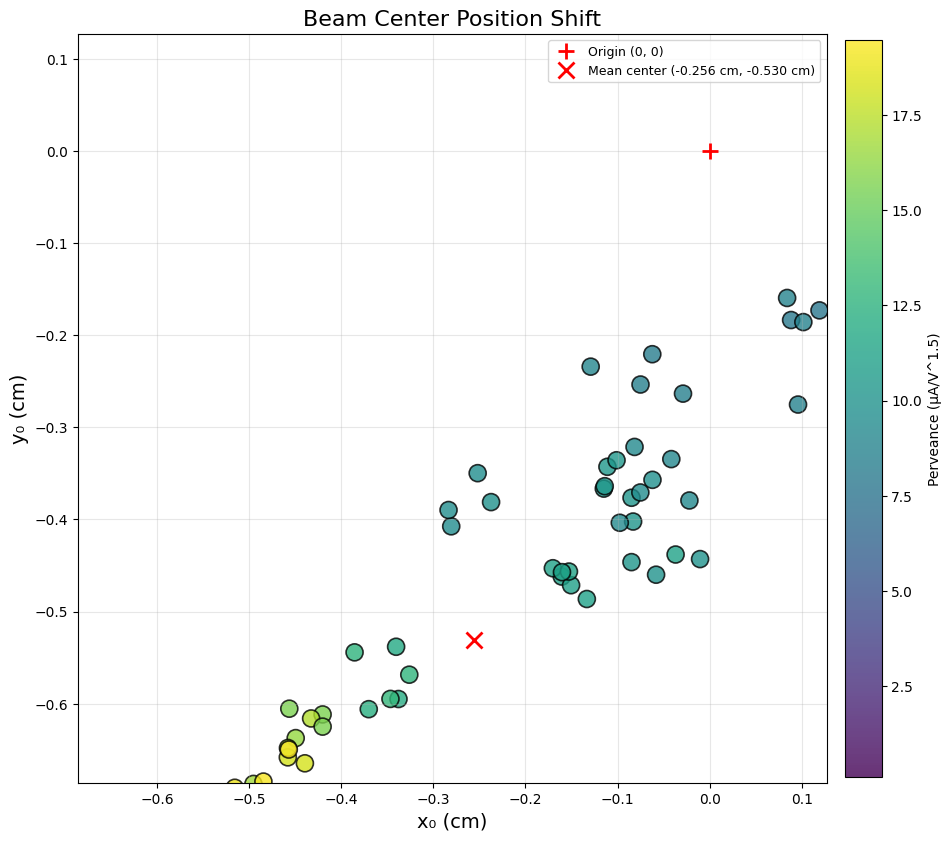


Beam center statistics (inches):
  x₀: -0.1007 ± 0.4154 inches
  y₀: -0.2088 ± 0.2027 inches


In [99]:
# Corrected FIGURE 7: Beam center positions colored by perveance (μA/V^1.5)
# This cell re-plots the beam centers using cm units and perveance for the color scale.
if 'fit_df_aperture' in globals() and not fit_df_aperture.empty:
    df = fit_df_aperture.copy()
    # convert positions to cm and perveance to μA/V^1.5
    df['x0_cm'] = df['x0 (in)'] * 2.54
    df['y0_cm'] = df['y0 (in)'] * 2.54
    df['Perveance_uA'] = df['Perveance (A/V^1.5)'] * 1e6

    # Print table of shots with perveance (converted to μA/V^1.5)
    shot_table = df[['Shot', 'x0 (in)', 'y0 (in)', 'Perveance (A/V^1.5)', 'Beam_V (kV)', 'Beam_E (kJ)']].copy()
    shot_table['Shot_Number'] = shot_table['Shot'].apply(lambda x: int(Path(x).stem))
    shot_table['Perveance (μA/V^1.5)'] = shot_table['Perveance (A/V^1.5)'] * 1e6
    shot_table = shot_table.sort_values('y0 (in)')
    print(shot_table[['Shot_Number', 'x0 (in)', 'y0 (in)', 'Perveance (μA/V^1.5)', 'Beam_V (kV)', 'Beam_E (kJ)']].to_string(index=False))

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    sc = ax.scatter(df['x0_cm'], df['y0_cm'],
                    c=df['Perveance_uA'], s=150, alpha=0.8,
                    edgecolor='black', cmap='viridis', linewidth=1.2)

    # Mark origin and mean center (mean computed in inches, converted to cm for plotting)
    ax.plot(0, 0, 'r+', markersize=12, markeredgewidth=2, label='Origin (0, 0)')
    mean_x0_in = df['x0 (in)'].mean()
    mean_y0_in = df['y0 (in)'].mean()
    mean_x0_cm = mean_x0_in * 2.54
    mean_y0_cm = mean_y0_in * 2.54
    ax.plot(mean_x0_cm, mean_y0_cm, 'rx', markersize=12, markeredgewidth=2,
            label=f'Mean center ({mean_x0_cm:.3f} cm, {mean_y0_cm:.3f} cm)')

    ax.set_xlabel('x₀ (cm)', fontsize=14)
    ax.set_ylabel('y₀ (cm)', fontsize=14)
    ax.set_title('Beam Center Position Shift', fontsize=16)
    ax.grid(True, alpha=0.3)

    # Convert original axis limits from inches to cm
    ax.set_xlim(-0.27 * 2.54, 0.05 * 2.54)
    ax.set_ylim(-0.27 * 2.54, 0.05 * 2.54)
    ax.set_aspect('equal', adjustable='box')

    cb = plt.colorbar(sc, ax=ax, pad=0.02, aspect=20, shrink=0.76, label='Perveance (μA/V^1.5)')
    ax.legend(loc='best', fontsize=9)
    plt.tight_layout()
    plt.show()

    print(f"\nBeam center statistics (inches):")
    print(f"  x₀: {mean_x0_in:.4f} ± {df['x0 (in)'].std():.4f} inches")
    print(f"  y₀: {mean_y0_in:.4f} ± {df['y0 (in)'].std():.4f} inches")
else:
    print('fit_df_aperture not found or empty; run prior cells to create it.')


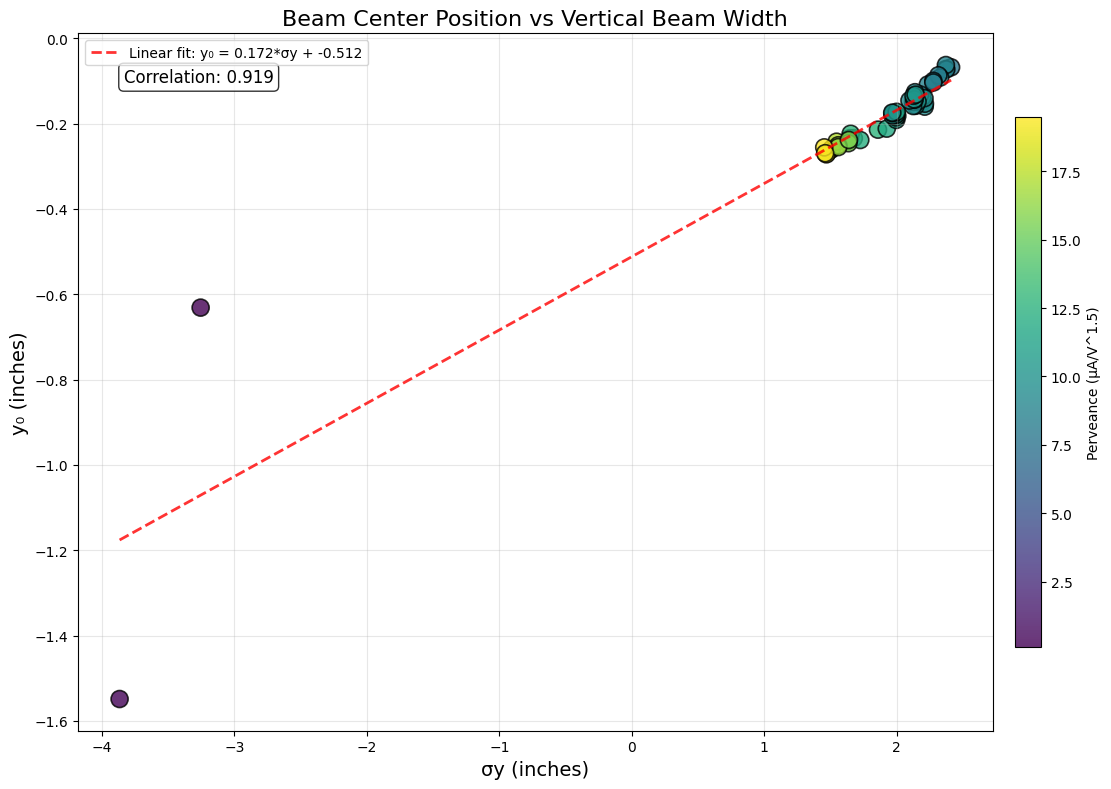

Correlation between σy and y₀: 0.9187
Linear fit: y₀ = 0.1717 * σy + -0.5121
σy range: -3.8660 to 2.4103 inches
y₀ range: -1.5488 to -0.0628 inches


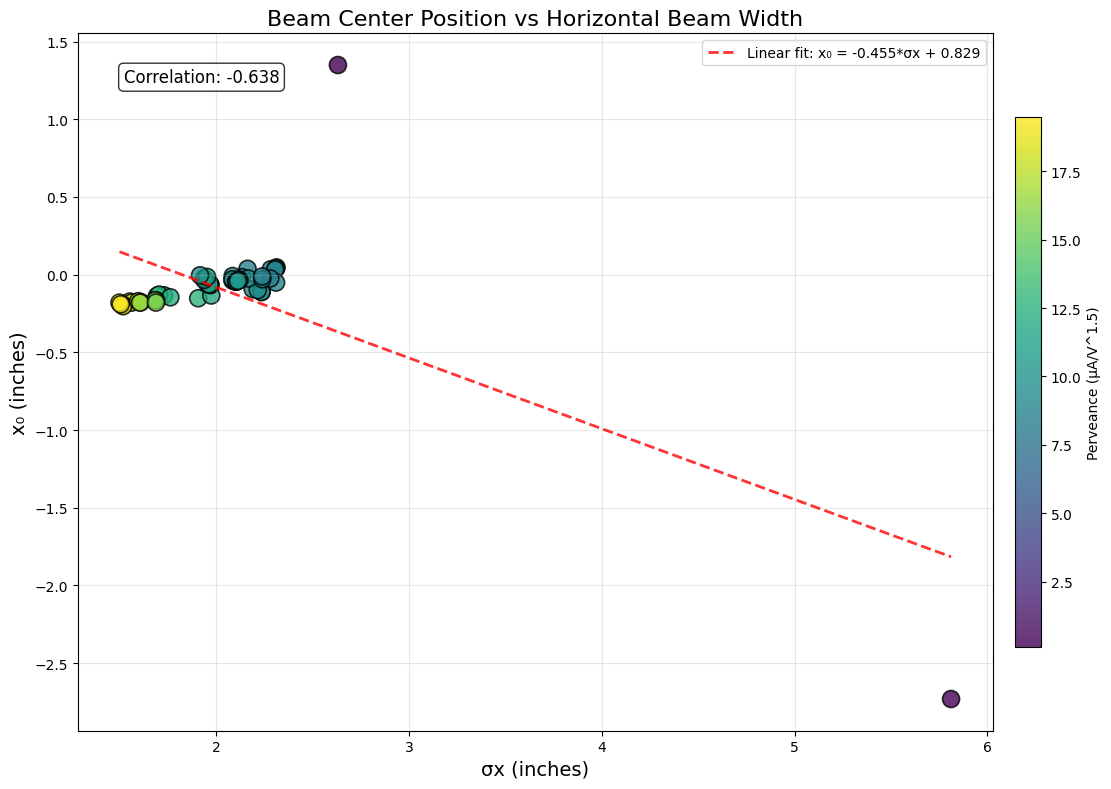


Correlation between σx and x₀: -0.6383
Linear fit: x₀ = -0.4551 * σx + 0.8291


In [100]:
# Beam Center Position vs Beam Width Analysis
# Plot y0 vs sigma_y colored by perveance to see scaling relationship

if 'fit_df_aperture' in globals() and not fit_df_aperture.empty:
    df = fit_df_aperture.copy()
    df['Perveance_uA'] = df['Perveance (A/V^1.5)'] * 1e6
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Plot y0 vs sigma_y colored by perveance
    scatter = ax.scatter(df['sigma_y (in)'], df['y0 (in)'],
                        c=df['Perveance_uA'], s=150, alpha=0.8,
                        edgecolor='black', cmap='viridis', linewidth=1.2)
    
    # Add trend line
    z = np.polyfit(df['sigma_y (in)'], df['y0 (in)'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(df['sigma_y (in)'].min(), df['sigma_y (in)'].max(), 100)
    ax.plot(x_line, p(x_line), 'r--', linewidth=2, alpha=0.8,
            label=f'Linear fit: y₀ = {z[0]:.3f}*σy + {z[1]:.3f}')
    
    ax.set_xlabel('σy (inches)', fontsize=14)
    ax.set_ylabel('y₀ (inches)', fontsize=14)
    ax.set_title('Beam Center Position vs Vertical Beam Width', fontsize=16)
    ax.grid(True, alpha=0.3)
    
    # Add correlation coefficient
    corr = df[['sigma_y (in)', 'y0 (in)']].corr().iloc[0, 1]
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=12, verticalalignment='top')
    
    cb = plt.colorbar(scatter, ax=ax, pad=0.02, aspect=20, shrink=0.76, 
                     label='Perveance (μA/V^1.5)')
    ax.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Correlation between σy and y₀: {corr:.4f}")
    print(f"Linear fit: y₀ = {z[0]:.4f} * σy + {z[1]:.4f}")
    print(f"σy range: {df['sigma_y (in)'].min():.4f} to {df['sigma_y (in)'].max():.4f} inches")
    print(f"y₀ range: {df['y0 (in)'].min():.4f} to {df['y0 (in)'].max():.4f} inches")
    
    # Additional analysis: x0 vs sigma_x for comparison
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    scatter = ax.scatter(df['sigma_x (in)'], df['x0 (in)'],
                        c=df['Perveance_uA'], s=150, alpha=0.8,
                        edgecolor='black', cmap='viridis', linewidth=1.2)
    
    # Add trend line
    z_x = np.polyfit(df['sigma_x (in)'], df['x0 (in)'], 1)
    p_x = np.poly1d(z_x)
    x_line_x = np.linspace(df['sigma_x (in)'].min(), df['sigma_x (in)'].max(), 100)
    ax.plot(x_line_x, p_x(x_line_x), 'r--', linewidth=2, alpha=0.8,
            label=f'Linear fit: x₀ = {z_x[0]:.3f}*σx + {z_x[1]:.3f}')
    
    ax.set_xlabel('σx (inches)', fontsize=14)
    ax.set_ylabel('x₀ (inches)', fontsize=14)
    ax.set_title('Beam Center Position vs Horizontal Beam Width', fontsize=16)
    ax.grid(True, alpha=0.3)
    
    corr_x = df[['sigma_x (in)', 'x0 (in)']].corr().iloc[0, 1]
    ax.text(0.05, 0.95, f'Correlation: {corr_x:.3f}', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=12, verticalalignment='top')
    
    cb = plt.colorbar(scatter, ax=ax, pad=0.02, aspect=20, shrink=0.76,
                     label='Perveance (μA/V^1.5)')
    ax.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    print(f"\nCorrelation between σx and x₀: {corr_x:.4f}")
    print(f"Linear fit: x₀ = {z_x[0]:.4f} * σx + {z_x[1]:.4f}")
    
else:
    print('fit_df_aperture not found or empty; run prior cells to create it.')


BEAM POSITION VS NORMALIZED ΔT ANALYSIS

Successfully merged 55 shots with both fit data and normalized ΔT
55 shots have complete data for plotting


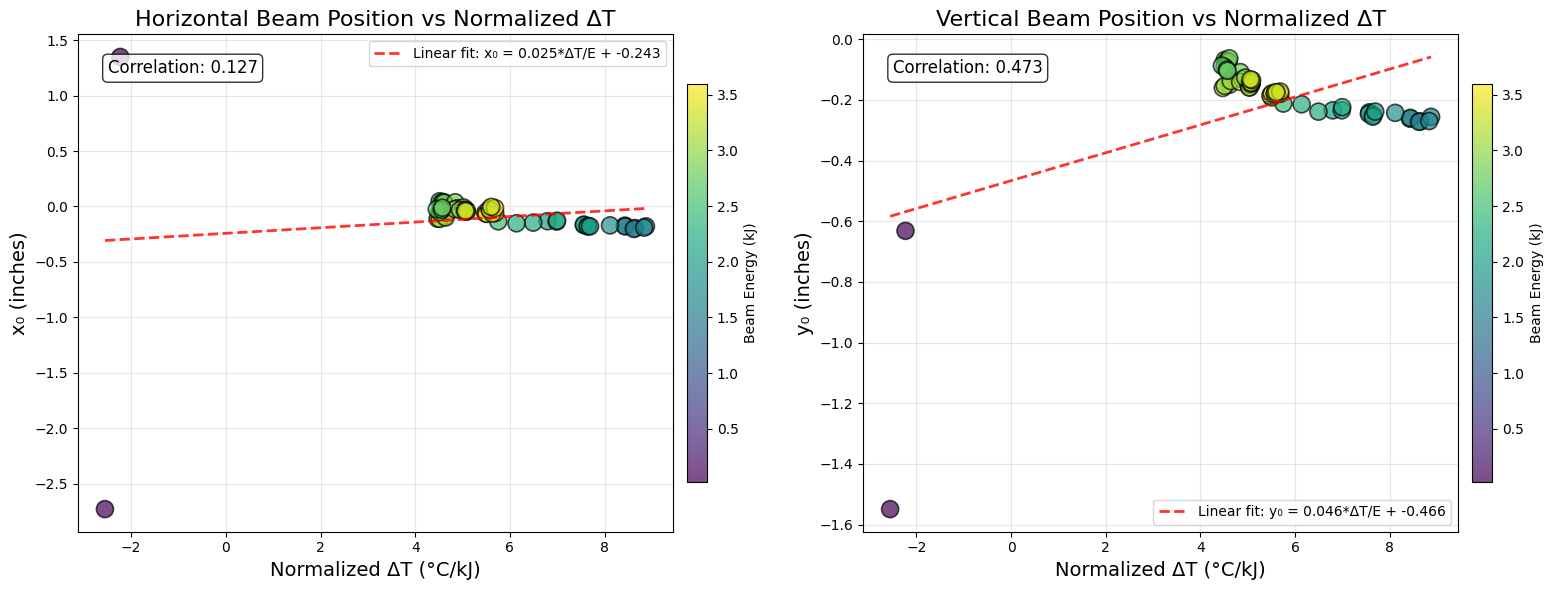


=== X-Position Analysis ===
Correlation between ΔT/E and x₀: 0.1271
Linear fit: x₀ = 0.0253 * (ΔT/E) + -0.2425
ΔT/E range: -2.5543 to 8.8727 °C/kJ
x₀ range: -2.7308 to 1.3490 inches

=== Y-Position Analysis ===
Correlation between ΔT/E and y₀: 0.4726
Linear fit: y₀ = 0.0460 * (ΔT/E) + -0.4661
y₀ range: -1.5488 to -0.0628 inches


In [101]:
# BEAM POSITION VS NORMALIZED DELTA T

print("\n" + "="*100)
print("BEAM POSITION VS NORMALIZED ΔT ANALYSIS")
print("="*100)

# Check if fit_df and shot_avg dataframes exist
if 'fit_df' in locals() and 'shot_avg' in locals() and not fit_df.empty and not shot_avg.empty:
    
    # Merge fit_df with shot_avg to get normalized delta T
    # shot_avg has Avg_ΔT/E which is the normalized delta T per shot
    merged_df = fit_df.merge(
        shot_avg[['Shot', 'Avg_ΔT/E', 'Avg_ΔT', 'Beam_E']], 
        on='Shot', 
        how='inner'
    )
    
    print(f"\nSuccessfully merged {len(merged_df)} shots with both fit data and normalized ΔT")
    
    # Remove any rows with NaN in key columns
    merged_df_clean = merged_df.dropna(subset=['x0 (in)', 'y0 (in)', 'Avg_ΔT/E'])
    
    print(f"{len(merged_df_clean)} shots have complete data for plotting")
    
    if not merged_df_clean.empty:
        # Create two separate plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: x0 vs Normalized ΔT
        scatter1 = ax1.scatter(merged_df_clean['Avg_ΔT/E'], merged_df_clean['x0 (in)'],
                              s=150, alpha=0.7, edgecolor='black', linewidth=1.2,
                              c=merged_df_clean['Beam_E'], cmap='viridis')
        
        # Add trend line for x0
        z_x = np.polyfit(merged_df_clean['Avg_ΔT/E'], merged_df_clean['x0 (in)'], 1)
        p_x = np.poly1d(z_x)
        x_line = np.linspace(merged_df_clean['Avg_ΔT/E'].min(), 
                            merged_df_clean['Avg_ΔT/E'].max(), 100)
        ax1.plot(x_line, p_x(x_line), 'r--', linewidth=2, alpha=0.8,
                label=f'Linear fit: x₀ = {z_x[0]:.3f}*ΔT/E + {z_x[1]:.3f}')
        
        ax1.set_xlabel('Normalized ΔT (°C/kJ)', fontsize=14)
        ax1.set_ylabel('x₀ (inches)', fontsize=14)
        ax1.set_title('Horizontal Beam Position vs Normalized ΔT', fontsize=16)
        ax1.grid(True, alpha=0.3)
        
        # Add correlation coefficient
        corr_x = merged_df_clean[['Avg_ΔT/E', 'x0 (in)']].corr().iloc[0, 1]
        ax1.text(0.05, 0.95, f'Correlation: {corr_x:.3f}', transform=ax1.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=12, verticalalignment='top')
        
        ax1.legend(loc='best', fontsize=10)
        
        # Add colorbar for beam energy
        cb1 = plt.colorbar(scatter1, ax=ax1, pad=0.02, aspect=20, shrink=0.8,
                          label='Beam Energy (kJ)')
        
        # Plot 2: y0 vs Normalized ΔT
        scatter2 = ax2.scatter(merged_df_clean['Avg_ΔT/E'], merged_df_clean['y0 (in)'],
                              s=150, alpha=0.7, edgecolor='black', linewidth=1.2,
                              c=merged_df_clean['Beam_E'], cmap='viridis')
        
        # Add trend line for y0
        z_y = np.polyfit(merged_df_clean['Avg_ΔT/E'], merged_df_clean['y0 (in)'], 1)
        p_y = np.poly1d(z_y)
        ax2.plot(x_line, p_y(x_line), 'r--', linewidth=2, alpha=0.8,
                label=f'Linear fit: y₀ = {z_y[0]:.3f}*ΔT/E + {z_y[1]:.3f}')
        
        ax2.set_xlabel('Normalized ΔT (°C/kJ)', fontsize=14)
        ax2.set_ylabel('y₀ (inches)', fontsize=14)
        ax2.set_title('Vertical Beam Position vs Normalized ΔT', fontsize=16)
        ax2.grid(True, alpha=0.3)
        
        # Add correlation coefficient
        corr_y = merged_df_clean[['Avg_ΔT/E', 'y0 (in)']].corr().iloc[0, 1]
        ax2.text(0.05, 0.95, f'Correlation: {corr_y:.3f}', transform=ax2.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                fontsize=12, verticalalignment='top')
        
        ax2.legend(loc='best', fontsize=10)
        
        # Add colorbar for beam energy
        cb2 = plt.colorbar(scatter2, ax=ax2, pad=0.02, aspect=20, shrink=0.8,
                          label='Beam Energy (kJ)')
        
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"\n=== X-Position Analysis ===")
        print(f"Correlation between ΔT/E and x₀: {corr_x:.4f}")
        print(f"Linear fit: x₀ = {z_x[0]:.4f} * (ΔT/E) + {z_x[1]:.4f}")
        print(f"ΔT/E range: {merged_df_clean['Avg_ΔT/E'].min():.4f} to {merged_df_clean['Avg_ΔT/E'].max():.4f} °C/kJ")
        print(f"x₀ range: {merged_df_clean['x0 (in)'].min():.4f} to {merged_df_clean['x0 (in)'].max():.4f} inches")
        
        print(f"\n=== Y-Position Analysis ===")
        print(f"Correlation between ΔT/E and y₀: {corr_y:.4f}")
        print(f"Linear fit: y₀ = {z_y[0]:.4f} * (ΔT/E) + {z_y[1]:.4f}")
        print(f"y₀ range: {merged_df_clean['y0 (in)'].min():.4f} to {merged_df_clean['y0 (in)'].max():.4f} inches")
        
    else:
        print("\nNo data available for plotting after cleaning")
        
else:
    print("\n⚠️  Required dataframes not found. Make sure to run:")
    print("  1. Cell with 2D Gaussian fitting (creates fit_df)")
    print("  2. Cell with segment analysis (creates shot_avg)")
    the


In [102]:
# Print all shots above 20 keV
if 'beam_energies' in dir():
    print("Shots above 20 keV from beam_energies dictionary:")
    shots_above_20kev = [(shot, energy) for shot, energy in beam_energies.items() if energy > 20]
    for shot, energy in sorted(shots_above_20kev):
        print(f"Shot {shot}: {energy:.2f} keV")
    print(f"\nTotal: {len(shots_above_20kev)} shots above 20 keV")

if 'beam_voltages' in dir():
    print("\n\nShots above 20 kV from beam_voltages dictionary:")
    shots_above_20kv = [(shot, voltage) for shot, voltage in beam_voltages.items() if voltage > 20]
    for shot, voltage in sorted(shots_above_20kv):
        print(f"Shot {shot}: {voltage:.2f} kV")
    print(f"\nTotal: {len(shots_above_20kv)} shots above 20 kV")

# Check if there's a merged_df or fit_df with beam energy
if 'merged_df' in dir():
    print("\n\nFrom merged_df:")
    if 'beam_energy' in merged_df.columns:
        high_energy_df = merged_df[merged_df['beam_energy'] > 20].copy()
        if not high_energy_df.empty:
            print(high_energy_df[['shot_number', 'beam_energy']].drop_duplicates().sort_values('shot_number'))
            print(f"\nTotal: {len(high_energy_df['shot_number'].unique())} shots above 20 keV")
    elif 'avg_beam_voltage' in merged_df.columns:
        high_energy_df = merged_df[merged_df['avg_beam_voltage'] > 20].copy()
        if not high_energy_df.empty:
            print(high_energy_df[['shot_number', 'avg_beam_voltage']].drop_duplicates().sort_values('shot_number'))
            print(f"\nTotal: {len(high_energy_df['shot_number'].unique())} shots above 20 kV")

if 'fit_df' in dir():
    print("\n\nFrom fit_df:")
    if 'beam_energy' in fit_df.columns:
        high_energy_df = fit_df[fit_df['beam_energy'] > 20].copy()
        if not high_energy_df.empty:
            print(high_energy_df[['shot_number', 'beam_energy']].drop_duplicates().sort_values('shot_number'))
            print(f"\nTotal: {len(high_energy_df['shot_number'].unique())} shots above 20 keV")
    elif 'avg_beam_voltage' in fit_df.columns:
        high_energy_df = fit_df[fit_df['avg_beam_voltage'] > 20].copy()
        if not high_energy_df.empty:
            print(high_energy_df[['shot_number', 'avg_beam_voltage']].drop_duplicates().sort_values('shot_number'))
            print(f"\nTotal: {len(high_energy_df['shot_number'].unique())} shots above 20 kV")

Shots above 20 keV from beam_energies dictionary:

Total: 0 shots above 20 keV


Shots above 20 kV from beam_voltages dictionary:
Shot 112708.txt: 20.61 kV
Shot 112716.txt: 20.61 kV
Shot 112717.txt: 20.74 kV
Shot 112727.txt: 20.74 kV
Shot 113260.txt: 20.59 kV
Shot 113261.txt: 20.72 kV
Shot 113262.txt: 20.74 kV
Shot 113263.txt: 20.67 kV
Shot 113264.txt: 20.61 kV
Shot 113265.txt: 21.34 kV
Shot 113267.txt: 21.21 kV
Shot 113268.txt: 20.58 kV
Shot 113269.txt: 20.64 kV
Shot 113270.txt: 20.67 kV
Shot 113271.txt: 20.51 kV
Shot 113272.txt: 21.33 kV
Shot 113273.txt: 20.68 kV
Shot 113274.txt: 20.58 kV
Shot 113275.txt: 20.68 kV
Shot 113276.txt: 20.60 kV
Shot 113277.txt: 20.45 kV
Shot 113278.txt: 20.63 kV
Shot 113279.txt: 20.55 kV
Shot 113280.txt: 20.48 kV
Shot 113281.txt: 20.55 kV
Shot 113282.txt: 20.66 kV
Shot 113283.txt: 20.48 kV
Shot 113284.txt: 20.52 kV
Shot 113285.txt: 20.61 kV
Shot 113297.txt: 20.68 kV
Shot 113298.txt: 20.60 kV
Shot 113299.txt: 20.66 kV
Shot 113300.txt: 20.74 kV
Shot 113301.